In [2]:
import random as random
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit
from utils_copy import al_integrity_testt
from old_for_testing.sp_approx import sp_approx
from old_for_testing.utils import *


score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5



In [4]:
random_sequences_collection=[]
for i in range(0,100):
    random_pile=[]
    for j in range (0,10):
        a_sequence=[]
        for k in range(0,random.randrange(5,10)):
            a_sequence.append(random.choice(['a','c','t','g']))
        random_pile.append(a_sequence)
    random_sequences_collection.append(random_pile)

print(random_sequences_collection)

[[['c', 't', 'a', 't', 'a', 'a', 'a', 'c'], ['c', 'g', 't', 't', 'c', 't', 'c', 'c', 'g'], ['g', 'g', 'a', 't', 'a', 't', 'g'], ['a', 'a', 'a', 'c', 'c', 't', 'a', 'c'], ['t', 'a', 't', 't', 'g', 'c', 'g', 'c'], ['t', 'a', 'c', 'c', 't', 'a', 'a', 't'], ['g', 'c', 'c', 'g', 'g', 'c'], ['t', 't', 'a', 'a', 'c', 'a', 'a', 'c'], ['a', 'c', 'c', 'g', 't'], ['g', 'g', 'g', 't', 'c', 't', 't', 'a']], [['g', 'c', 'g', 't', 'g', 'g', 'a'], ['a', 'g', 'c', 't', 't', 'c', 'g', 'a'], ['a', 't', 'a', 'a', 'c', 'g'], ['t', 'a', 't', 'g', 'g'], ['t', 'g', 'c', 'a', 't', 't', 'g'], ['g', 't', 'c', 'a', 't', 't'], ['a', 't', 'a', 'c', 'c', 'c', 't'], ['a', 'c', 'a', 'c', 'g', 'g'], ['a', 't', 't', 'g', 'g'], ['c', 'c', 'g', 'a', 't', 'a', 'a']], [['c', 'c', 'a', 'g', 't'], ['g', 'g', 'c', 'c', 'c', 'c'], ['c', 'c', 't', 't', 'g', 'a', 'c', 'g'], ['c', 'g', 'c', 'a', 'a'], ['t', 't', 'c', 'c', 'g'], ['c', 'a', 'g', 't', 'g', 'c', 'c', 'c', 't'], ['g', 't', 'g', 'g', 'a', 'g', 'g', 'a'], ['g', 't', 'g',

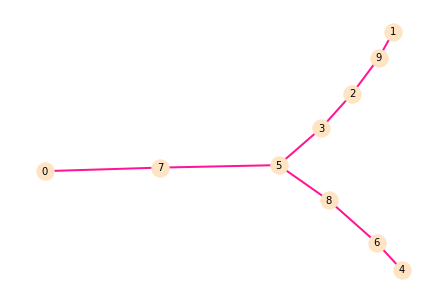

this is A_dict: 
{'0_7': [['c', 't'], ['t', 't'], ['a', 'a'], ['t', 'a'], ['a', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c']], '5_7': [['t', '-'], ['t', 't'], ['a', 'a'], ['a', 'c'], ['c', 'c'], ['-', 't'], ['a', 'a'], ['a', 'a'], ['c', 't']], '3_5': [['-', 'a'], ['t', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', '-'], ['a', 'a'], ['t', 'c']], '5_8': [['t', '-'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', '-'], ['a', '-'], ['a', 'g'], ['t', 't']], '2_3': [['a', 'g'], ['a', 'g'], ['a', 'a'], ['c', 't'], ['c', 'a'], ['t', 't'], ['a', 'g'], ['c', '-']], '6_8': [['a', 'g'], ['c', 'c'], ['c', 'c'], ['-', 'g'], ['g', 'g'], ['t', 'c']], '2_9': [['g', 'g'], ['g', 'g'], ['a', 'g'], ['t', 't'], ['-', 'c'], ['a', 't'], ['t', 't'], ['g', 'a']], '4_6': [['-', 't'], ['g', 'a'], ['c', 't'], ['c', 't'], ['g', 'g'], ['-', 'c'], ['g', 'g'], ['c', 'c']], '1_9': [['g', 'c'], ['g', 'g'], ['g', 't'], ['t', 't'], ['c', 'c'], ['t', 't'], ['-', 'c'], ['t', 'c'], ['a', 'g']]}
Total cost of MSA:1214


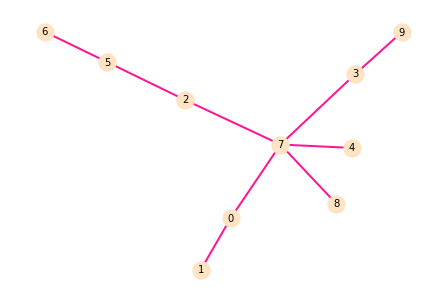

this is A_dict: 
{'5_6': [['a', 'g'], ['t', 't'], ['a', '-'], ['c', 'c'], ['c', 'a'], ['c', 't'], ['t', 't']], '2_5': [['g', 'a'], ['t', 't'], ['c', 'a'], ['a', 'a'], ['t', 'c'], ['t', 'g']], '2_7': [['a', 'a'], ['t', 'c'], ['a', 'a'], ['a', 'c'], ['c', 'g'], ['g', 'g']], '3_7': [['a', '-'], ['c', 't'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['g', 'g']], '7_8': [['a', 'a'], ['c', 't'], ['a', '-'], ['c', 't'], ['g', 'g'], ['g', 'g']], '0_7': [['a', 'g'], ['c', 'c'], ['a', 'g'], ['c', 't'], ['g', 'g'], ['g', 'g'], ['-', 'a']], '4_7': [['-', 't'], ['a', 'g'], ['c', 'c'], ['a', 'a'], ['c', 't'], ['g', 't'], ['g', 'g']], '3_9': [['-', 'c'], ['t', 'c'], ['-', 'g'], ['a', 'a'], ['t', 't'], ['g', 'a'], ['g', 'a']], '0_1': [['-', 'a'], ['g', 'g'], ['c', 'c'], ['g', 't'], ['t', 't'], ['g', 'c'], ['g', 'g'], ['a', 'a']]}
Total cost of MSA:933


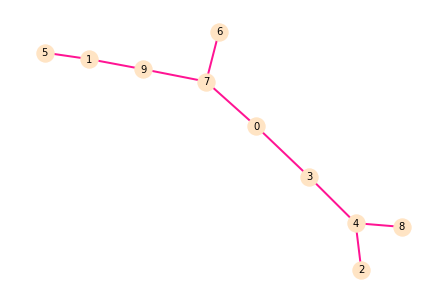

this is A_dict: 
{'1_5': [['c', '-'], ['a', '-'], ['g', 'g'], ['t', '-'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['t', 'c']], '1_9': [['g', 'a'], ['g', 'c'], ['c', 'g'], ['c', 'c'], ['c', 't'], ['c', 't']], '7_9': [['a', 'g'], ['c', 't'], ['g', 'g'], ['c', 'g'], ['t', 't'], ['t', 'g']], '0_7': [['g', 'c'], ['t', 'c'], ['g', 'a'], ['g', 'g'], ['t', 't'], ['g', '-']], '6_7': [['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['-', 'a'], ['t', 'g'], ['g', 'g'], ['-', 'a']], '0_3': [['c', 'c'], ['-', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'a'], ['t', '-']], '3_4': [['c', 't'], ['g', 't'], ['c', 'c'], ['a', 'c'], ['a', 'g']], '4_8': [['t', 't'], ['t', 't'], ['-', 'a'], ['-', 'a'], ['-', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'a']], '2_4': [['-', 'c'], ['t', 'c'], ['t', 't'], ['c', 't'], ['-', 'g'], ['-', 'a'], ['c', 'c'], ['g', 'g']]}
Total cost of MSA:1418


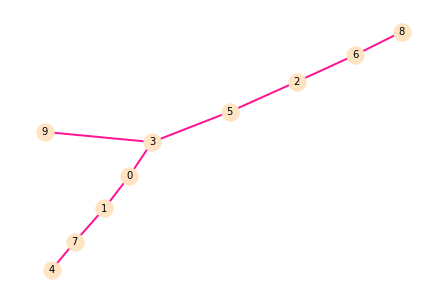

this is A_dict: 
{'4_7': [['t', '-'], ['t', 'c'], ['t', 't'], ['c', 'c'], ['c', 'g'], ['t', 't'], ['g', 'g'], ['-', 'a']], '1_7': [['c', '-'], ['t', 't'], ['c', '-'], ['g', 'g'], ['t', 'g'], ['g', 'g'], ['a', 'a']], '0_1': [['-', 'g'], ['t', 't'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['g', 'c'], ['a', 't']], '0_3': [['-', 'c'], ['g', 'a'], ['t', 't'], ['g', 'a'], ['-', 'c'], ['t', 't'], ['g', 'a'], ['c', 'a'], ['t', 't']], '3_9': [['c', 't'], ['a', 'g'], ['t', 'c'], ['a', 'c'], ['c', 'c'], ['t', 'c'], ['a', 'a'], ['a', 'a'], ['t', 'c']], '3_5': [['c', 'c'], ['a', 'a'], ['t', 'a'], ['a', 'a'], ['c', 'g'], ['t', 'c'], ['a', 'a'], ['a', 'g'], ['t', 'g']], '2_5': [['c', 't'], ['a', 't'], ['a', 'a'], ['a', 'g'], ['g', 'a'], ['c', 't'], ['a', 'a'], ['g', 'c'], ['g', 'g']], '2_6': [['-', 'a'], ['t', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['a', 'g'], ['t', 't'], ['a', 'a'], ['c', 't'], ['g', '-']], '6_8': [['a', 'a'], ['a', 'g'], ['t', 'g'], ['a', 'a'], ['g', 'c'], ['g', 'g'], ['t', 'g'], ['

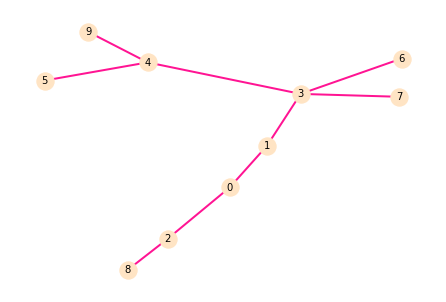

this is A_dict: 
{'0_2': [['-', 'a'], ['c', 'c'], ['t', 't'], ['c', 't'], ['c', 'c'], ['a', 'a']], '0_1': [['c', 'c'], ['t', 'g'], ['c', 'c'], ['c', 'a'], ['a', 'c']], '2_8': [['-', 'a'], ['a', 'a'], ['c', 'g'], ['t', 't'], ['t', 't'], ['c', 't'], ['a', 'g']], '1_3': [['c', 't'], ['g', 'a'], ['c', 'g'], ['a', 'a'], ['c', 't']], '3_6': [['t', 'c'], ['a', 't'], ['g', 'a'], ['a', 'a'], ['t', 't']], '3_4': [['t', 't'], ['a', 'a'], ['g', 'c'], ['a', 'a'], ['t', 't'], ['-', 'g']], '3_7': [['-', 'g'], ['-', 'g'], ['t', 'g'], ['a', 'a'], ['-', 'g'], ['g', 'g'], ['a', 'a'], ['t', 'c']], '4_5': [['t', 'g'], ['a', 'a'], ['-', 't'], ['c', 'c'], ['a', 'a'], ['t', 'c'], ['g', 'g']], '4_9': [['-', 't'], ['-', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['-', 'a']]}
Total cost of MSA:1121


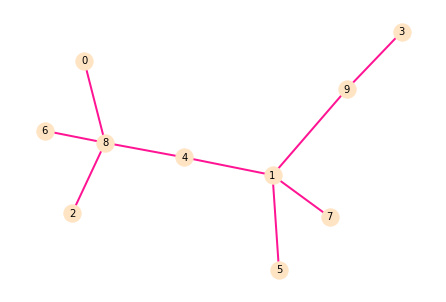

this is A_dict: 
{'2_8': [['t', 't'], ['-', 'a'], ['c', 'c'], ['c', 't'], ['a', 'a'], ['t', 'c'], ['g', 'c'], ['g', 't'], ['g', 'g']], '6_8': [['t', 'g'], ['a', 'g'], ['c', 'g'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 'g'], ['g', 'g']], '0_8': [['t', 't'], ['a', '-'], ['c', 't'], ['t', 't'], ['a', 'a'], ['c', 't'], ['-', 'a'], ['c', 'c'], ['t', 't'], ['g', 'c']], '4_8': [['t', 't'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', '-'], ['c', '-'], ['t', '-'], ['g', '-']], '1_4': [['t', 'c'], ['a', 'g'], ['-', 't'], ['c', 't'], ['t', 't'], ['a', 'c']], '1_9': [['c', 'c'], ['g', '-'], ['t', 't'], ['t', 'g'], ['t', 't'], ['c', 'c']], '1_7': [['c', 'a'], ['g', 'g'], ['t', 'c'], ['t', 'c'], ['t', 'c'], ['c', 't']], '1_5': [['c', 't'], ['-', 'g'], ['-', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['c', 't']], '3_9': [['c', 'c'], ['t', 'g'], ['g', 'g'], ['t', 'a'], ['c', 't']]}
Total cost of MSA:1411


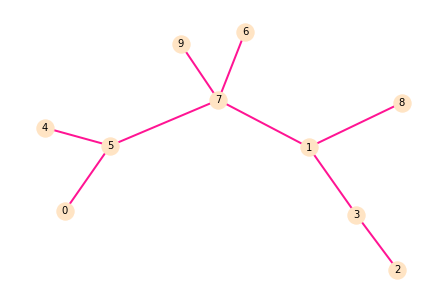

this is A_dict: 
{'0_5': [['a', 'a'], ['t', 'c'], ['t', 't'], ['c', '-'], ['g', 'g'], ['c', 't'], ['t', 't'], ['c', 'c'], ['t', '-']], '5_7': [['a', 'g'], ['c', '-'], ['t', 't'], ['g', 'a'], ['t', 't'], ['t', 't'], ['c', 't']], '4_5': [['-', 't'], ['a', 'a'], ['c', 'c'], ['t', 'c'], ['g', 'c'], ['t', 't'], ['t', 'a'], ['c', 'c']], '1_7': [['g', 'a'], ['t', 't'], ['a', 'a'], ['t', 'a'], ['t', 'g'], ['t', 'g']], '6_7': [['-', 't'], ['g', 'g'], ['t', 't'], ['a', 'g'], ['t', 't'], ['-', 'g'], ['-', 'a'], ['t', 't'], ['t', 't']], '7_9': [['g', 'g'], ['t', 't'], ['-', 'a'], ['-', 'g'], ['a', 'a'], ['t', 't'], ['t', 'c'], ['t', 'c'], ['-', 'a']], '1_8': [['a', 'a'], ['t', 't'], ['-', 'g'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g']], '1_3': [['a', 'a'], ['t', 'c'], ['a', 'a'], ['-', 't'], ['-', 'c'], ['a', 'g'], ['g', 'g'], ['g', 'a'], ['-', 't']], '2_3': [['a', 'g'], ['c', 'g'], ['a', 'a'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'c'], ['t', 'g']]}
Total cost of MSA:1359


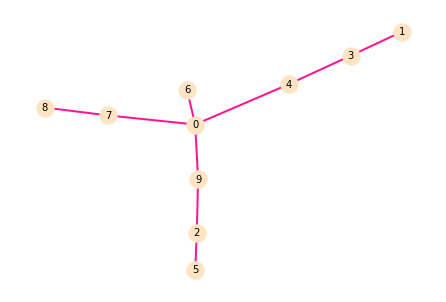

this is A_dict: 
{'1_3': [['c', 'c'], ['t', 'a'], ['c', 'c'], ['a', 'a'], ['-', 'c'], ['a', 'a'], ['t', 'c'], ['g', 'g'], ['t', '-'], ['g', 'g']], '3_4': [['c', 't'], ['a', '-'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['c', '-'], ['g', 'a'], ['g', 'a']], '0_4': [['t', '-'], ['c', '-'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['a', 'a']], '0_7': [['a', 'c'], ['c', 't'], ['a', 'g'], ['a', 't'], ['a', 'a']], '0_9': [['-', 't'], ['a', 'a'], ['c', 'c'], ['a', 't'], ['a', 'c'], ['a', 'g']], '0_6': [['-', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'g'], ['a', 'a'], ['a', 'g'], ['-', 't'], ['-', 't']], '7_8': [['c', 'c'], ['-', 'g'], ['t', 't'], ['-', 'c'], ['g', 'a'], ['t', 't'], ['a', 't']], '2_9': [['t', '-'], ['a', 'g'], ['c', 'c'], ['t', 't'], ['c', 't'], ['g', 'g'], ['-', 'c']], '2_5': [['g', 'g'], ['-', 'a'], ['-', 'a'], ['c', 'g'], ['t', 't'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['-', 'a']]}
Total cost of MSA:1404


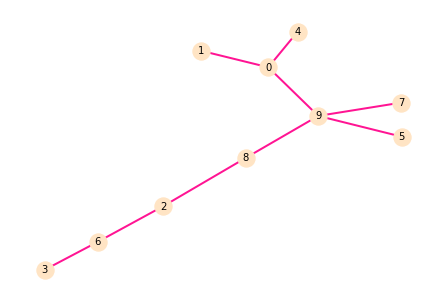

this is A_dict: 
{'0_1': [['g', 'g'], ['c', 'c'], ['t', '-'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['c', '-'], ['c', '-'], ['c', 'a']], '0_9': [['g', 'a'], ['c', 't'], ['a', 'g'], ['c', 'c'], ['a', '-'], ['a', 'a']], '0_4': [['g', 'g'], ['c', 't'], ['a', 'a'], ['c', 'a'], ['a', 'a'], ['a', 'a'], ['-', 'c']], '5_9': [['a', 'g'], ['t', 't'], ['g', 'g'], ['-', 't'], ['-', 't'], ['c', 'c'], ['a', 'a']], '8_9': [['a', '-'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['a', 'g'], ['-', 'c']], '7_9': [['a', 't'], ['t', 't'], ['g', 'g'], ['-', 'a'], ['c', 'c'], ['a', 't']], '2_8': [['t', 't'], ['g', 'g'], ['c', 'c'], ['-', 't'], ['g', 'g'], ['c', 't']], '2_6': [['t', 'c'], ['g', 'a'], ['c', 't'], ['t', 't'], ['g', 'g'], ['t', 'a']], '3_6': [['c', 'c'], ['a', 'a'], ['t', 'a'], ['t', 't'], ['g', 'c'], ['a', 'g']]}
Total cost of MSA:1069


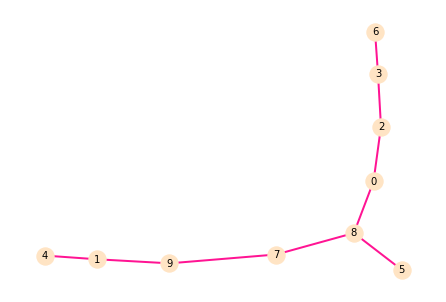

this is A_dict: 
{'1_9': [['a', 'g'], ['c', 't'], ['-', 'g'], ['t', 'a'], ['c', 'c'], ['c', 'c']], '1_4': [['a', 'g'], ['c', 't'], ['t', 't'], ['c', 't'], ['-', 'g'], ['c', 'c'], ['-', 'g'], ['-', 'a']], '7_9': [['g', 'a'], ['t', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c']], '7_8': [['a', 't'], ['g', 'g'], ['g', 'a'], ['a', 'a'], ['c', 't'], ['c', 'g']], '5_8': [['t', 'c'], ['g', 'c'], ['a', 'a'], ['a', 'a'], ['t', '-'], ['g', 'a']], '0_8': [['t', 'c'], ['g', 'g'], ['-', 'a'], ['-', 'c'], ['a', 'a'], ['-', 'c'], ['a', 'a'], ['t', 't'], ['g', 'a']], '0_2': [['-', 't'], ['c', 'c'], ['g', 'a'], ['a', 'a'], ['c', 't'], ['a', 'g'], ['c', 't'], ['a', 'a'], ['t', '-'], ['a', 'a']], '2_3': [['t', 'c'], ['c', 'c'], ['a', 'a'], ['a', 'g'], ['t', 't'], ['g', 'g'], ['t', '-'], ['a', 'g'], ['a', 't']], '3_6': [['c', 't'], ['c', 't'], ['a', 'g'], ['g', 'c'], ['t', 'c'], ['g', 't'], ['g', 'g'], ['t', 't']]}
Total cost of MSA:1404


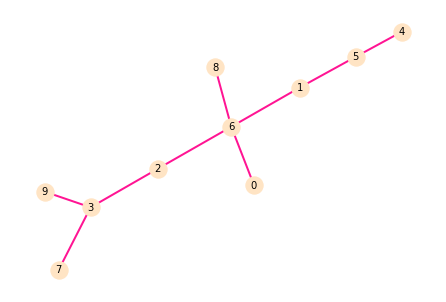

this is A_dict: 
{'6_8': [['t', 'c'], ['a', '-'], ['g', '-'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', '-'], ['c', 'c'], ['t', 'c']], '2_6': [['c', 'c'], ['a', 'a'], ['g', '-'], ['g', 'c'], ['c', 't'], ['c', 't']], '1_6': [['c', 'c'], ['a', 'g'], ['g', 'a'], ['-', 't'], ['-', 't'], ['g', 'g'], ['c', 't'], ['c', 'c']], '0_6': [['c', '-'], ['a', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'g'], ['c', 'a']], '2_3': [['c', '-'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['t', 't'], ['-', 'a'], ['-', 'c']], '1_5': [['c', 'c'], ['g', 'g'], ['a', 'c'], ['t', 'c'], ['t', 'a'], ['g', 'g'], ['t', 'c'], ['-', 'a'], ['c', 'c']], '3_7': [['a', 't'], ['c', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['-', 't'], ['c', 't']], '3_9': [['a', 'a'], ['c', 'c'], ['t', 't'], ['-', 'a'], ['t', 't'], ['-', 'c'], ['-', 'c'], ['a', 'a'], ['c', 'g']], '4_5': [['c', 'c'], ['g', 'c'], ['c', 'g'], ['c', 't'], ['a', 'g'], ['g', 'a'], ['c', 'c'], ['a', 'g'], ['c', 'c']]}
Total cost of MSA:1528


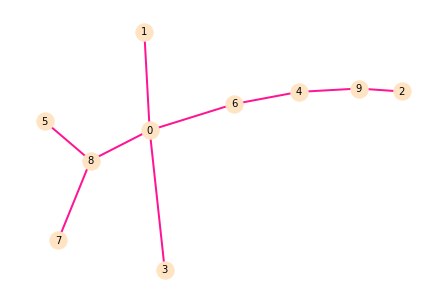

this is A_dict: 
{'2_9': [['t', 'c'], ['c', 't'], ['t', 't'], ['a', '-'], ['a', 't'], ['g', 'g'], ['g', 'g'], ['a', '-'], ['t', 't']], '4_9': [['c', 'c'], ['t', 'c'], ['t', 'g'], ['t', 't'], ['g', 'g'], ['g', 'a'], ['t', '-']], '4_6': [['c', 'a'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'a'], ['a', 'g'], ['-', 't']], '0_6': [['a', 'a'], ['c', 'g'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['-', 'c']], '0_3': [['a', 'g'], ['g', 'g'], ['g', 'a'], ['t', 'c'], ['a', 'a'], ['g', 'g'], ['t', 'c'], ['c', 'c']], '0_1': [['-', 'g'], ['a', 'a'], ['g', 'a'], ['g', 'a'], ['t', 't'], ['a', '-'], ['g', 'g'], ['t', 't'], ['-', 'g'], ['c', 'c']], '0_8': [['a', 't'], ['g', 'g'], ['g', 'a'], ['t', 't'], ['a', 'a'], ['g', 't'], ['t', 't'], ['-', 'a'], ['c', 'a']], '5_8': [['t', 't'], ['g', 'a'], ['a', 'g'], ['t', 'c'], ['a', 'c'], ['t', 't'], ['t', 't'], ['a', 'c'], ['a', 'g']], '7_8': [['-', 'a'], ['t', 't'], ['g', 'a'], ['a', 'a'], ['t', 'c'], ['a', '-'], ['t', 'c'], ['t', 'c'], ['

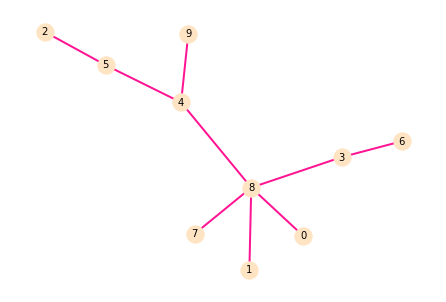

this is A_dict: 
{'0_8': [['a', 'a'], ['a', 't'], ['t', 'g'], ['t', 't'], ['c', 'g']], '3_8': [['-', 'g'], ['a', 'g'], ['t', 'c'], ['g', 'g'], ['t', '-'], ['g', 'g']], '7_8': [['a', 't'], ['t', 't'], ['g', 'a'], ['t', 'c'], ['g', 'g'], ['-', 'c']], '1_8': [['-', 'c'], ['a', 'c'], ['t', 't'], ['g', 'g'], ['t', 'a'], ['g', 'g']], '4_8': [['a', 'a'], ['t', 'c'], ['g', 'a'], ['-', 'c'], ['t', 't'], ['-', 'a'], ['g', 'a']], '3_6': [['g', 'g'], ['-', 'a'], ['-', 't'], ['g', 'g'], ['-', 't'], ['c', 'c'], ['-', 'g'], ['g', 'g'], ['g', 'g']], '4_5': [['a', 'c'], ['c', 'c'], ['-', 'g'], ['a', 'a'], ['c', 'c'], ['-', 'g'], ['t', 't'], ['a', 'g'], ['a', 'a']], '4_9': [['-', 'g'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['-', 'g'], ['c', 'a'], ['t', 'c'], ['a', 'a'], ['a', 'a']], '2_5': [['c', 'c'], ['c', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'g'], ['g', 'g'], ['t', 'c'], ['g', '-'], ['a', 'a']]}
Total cost of MSA:1359


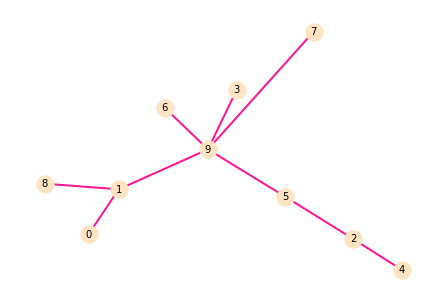

this is A_dict: 
{'2_4': [['g', 'g'], ['a', '-'], ['a', 'a'], ['g', 'c'], ['g', 'g'], ['a', 'a'], ['t', '-'], ['g', 'a'], ['t', 'c']], '2_5': [['g', 'g'], ['a', 't'], ['c', 'c'], ['g', '-'], ['a', '-'], ['a', 'a'], ['c', 'c']], '5_9': [['g', 'g'], ['t', 'c'], ['-', 'g'], ['c', 'c'], ['a', 't'], ['c', 't']], '7_9': [['g', 'a'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['t', 't']], '3_9': [['g', 'g'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['-', 'c'], ['-', 'a'], ['t', 't']], '1_9': [['g', 'g'], ['c', '-'], ['g', 'g'], ['c', 't'], ['t', 'c'], ['t', 't'], ['-', 'g']], '6_9': [['-', 't'], ['g', 'g'], ['c', 'c'], ['g', 't'], ['c', 'a'], ['t', 't'], ['t', 't']], '1_8': [['g', 'a'], ['g', 'g'], ['t', 'a'], ['c', 'c'], ['-', 'g'], ['t', 'c'], ['g', 'g']], '0_1': [['g', 'c'], ['g', 'g'], ['t', 't'], ['-', 'a'], ['c', 'g'], ['t', 't'], ['-', 'g'], ['g', 'g']]}
Total cost of MSA:1290


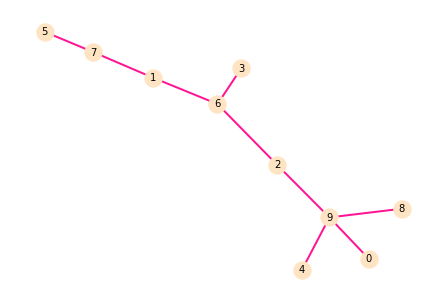

this is A_dict: 
{'3_6': [['c', '-'], ['c', '-'], ['g', 'g'], ['c', 'c'], ['a', 't'], ['t', 'c'], ['c', 'c'], ['a', 'a'], ['c', 't']], '2_6': [['g', 'g'], ['c', '-'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['t', 'g']], '1_6': [['g', 'g'], ['c', 'c'], ['t', 'g'], ['c', 'a'], ['c', 'a'], ['a', 'a'], ['t', 'c']], '2_9': [['g', '-'], ['t', 'c'], ['c', 'a'], ['c', 't'], ['a', 'a'], ['g', 'g']], '1_7': [['g', 'a'], ['c', 't'], ['g', 'g'], ['a', 'g'], ['a', 'g'], ['a', 't'], ['c', 't']], '8_9': [['c', 'a'], ['a', 'g'], ['t', 't'], ['a', 'g'], ['g', 'g']], '4_9': [['-', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', '-'], ['g', 'g']], '0_9': [['c', 't'], ['-', 'a'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['-', 'a']], '5_7': [['-', 't'], ['-', 't'], ['a', 'a'], ['t', 'c'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['t', 'c']]}
Total cost of MSA:1229


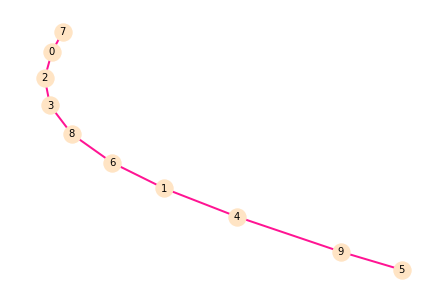

this is A_dict: 
{'0_2': [['t', 't'], ['t', 'g'], ['c', 'c'], ['a', 'a'], ['t', '-'], ['a', 'a'], ['g', 't'], ['a', 'a'], ['a', 'g']], '0_7': [['t', 'a'], ['t', 't'], ['c', 't'], ['a', 'g'], ['t', 'g'], ['a', 'a'], ['g', 'a'], ['a', 'a'], ['a', 't']], '2_3': [['t', 'c'], ['g', 'g'], ['c', '-'], ['a', 'g'], ['a', 'g'], ['t', 't'], ['-', 'a'], ['a', 'a'], ['g', 'a']], '3_8': [['c', 'g'], ['g', 'g'], ['g', 'a'], ['g', 'g'], ['t', 't'], ['a', 'g'], ['a', 'g'], ['-', 't'], ['a', 'a']], '6_8': [['g', 'g'], ['g', 'c'], ['a', 't'], ['g', 'g'], ['t', 't'], ['g', '-'], ['g', 'g'], ['t', 't'], ['a', 'a']], '1_6': [['g', 'g'], ['c', '-'], ['t', 't'], ['g', 'g'], ['t', '-'], ['g', 'g'], ['t', '-'], ['a', 'g']], '1_4': [['g', 'g'], ['t', 't'], ['g', 't'], ['g', 'a'], ['g', 't']], '4_9': [['g', 'g'], ['t', 'c'], ['t', 'c'], ['a', 'g'], ['t', 't']], '5_9': [['-', 'c'], ['g', 'g'], ['c', 'a'], ['c', 'c'], ['g', '-'], ['t', 'c']]}
Total cost of MSA:1355


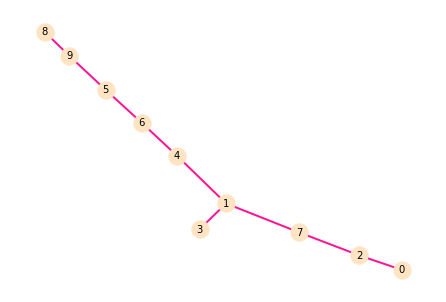

this is A_dict: 
{'5_6': [['t', 't'], ['c', 'c'], ['t', 't'], ['a', 't'], ['t', 'c'], ['t', 'c'], ['g', 'g'], ['a', 'c'], ['g', 'c']], '4_6': [['t', 'c'], ['c', 't'], ['t', 'c'], ['a', 'a'], ['t', '-'], ['t', 't'], ['g', '-'], ['a', '-'], ['g', 'g']], '5_9': [['t', 't'], ['c', 't'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'a'], ['g', 't'], ['c', 't'], ['c', 't']], '1_4': [['c', 'c'], ['t', '-'], ['c', 'c'], ['a', 'a'], ['t', 'g'], ['g', 'g']], '8_9': [['t', 'g'], ['t', 'a'], ['t', 'a'], ['t', 't'], ['c', 'a'], ['a', 'a'], ['t', 'c'], ['t', 't'], ['t', 'c']], '1_7': [['c', 't'], ['c', 'c'], ['a', 'g'], ['g', 'g'], ['g', 't']], '1_3': [['-', 'a'], ['-', 'a'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['-', 't'], ['g', 'g'], ['g', 'a']], '2_7': [['t', 'c'], ['c', 't'], ['g', 'g'], ['g', 't'], ['t', 'c']], '0_2': [['c', 't'], ['t', 't'], ['-', 'a'], ['-', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['-', 'g']]}
Total cost of MSA:1398


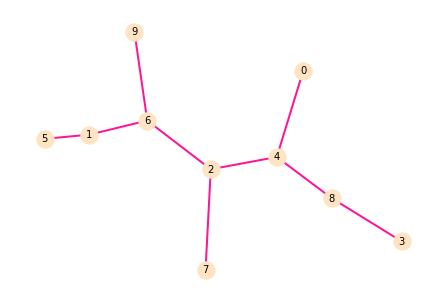

this is A_dict: 
{'3_8': [['c', 'c'], ['a', 'a'], ['c', 't'], ['a', 'g'], ['a', 'a']], '4_8': [['c', 'c'], ['a', '-'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['-', 'c']], '0_4': [['c', 't'], ['t', 'c'], ['g', 'g'], ['g', 'g'], ['-', 'a'], ['c', 't']], '2_4': [['c', 'a'], ['t', 'c'], ['g', 'c'], ['g', 'g'], ['c', 'c']], '2_7': [['a', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'a'], ['c', 't'], ['-', 'g']], '2_6': [['a', 'g'], ['c', 'c'], ['-', 't'], ['c', 'c'], ['g', 'g'], ['-', 't'], ['c', 'c']], '1_6': [['g', '-'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['-', 't'], ['t', 't'], ['c', 't']], '6_9': [['g', 'c'], ['c', 't'], ['-', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 't']], '1_5': [['c', 'c'], ['t', 'c'], ['c', 't'], ['g', 'g'], ['-', 'a'], ['t', 't'], ['t', 't'], ['-', 'c'], ['t', 't']]}
Total cost of MSA:1108


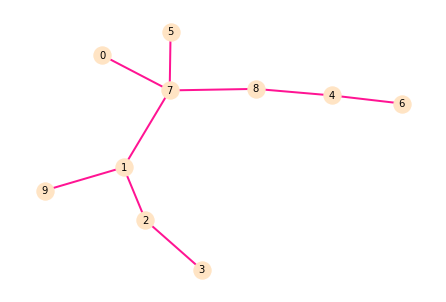

this is A_dict: 
{'2_3': [['c', 'a'], ['t', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['c', 'c']], '1_2': [['a', '-'], ['c', '-'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 'g'], ['c', 'c']], '1_9': [['g', 'g'], ['a', 'g'], ['g', 'a'], ['c', 'c'], ['g', '-'], ['c', 'c']], '1_7': [['g', '-'], ['a', 't'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['c', 'c']], '0_7': [['t', 't'], ['g', 't'], ['c', 'c'], ['g', 'c'], ['c', 'c']], '5_7': [['t', 't'], ['g', 'g'], ['c', 'c'], ['g', 'a'], ['-', 't'], ['c', 'c'], ['-', 'g']], '7_8': [['t', 't'], ['g', 'c'], ['c', 'g'], ['g', 'g'], ['c', 'g']], '4_8': [['-', 'g'], ['t', 'c'], ['c', 'c'], ['g', 't'], ['g', 'a'], ['g', 'a']], '4_6': [['-', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['-', 't'], ['a', 'g']]}
Total cost of MSA:1136


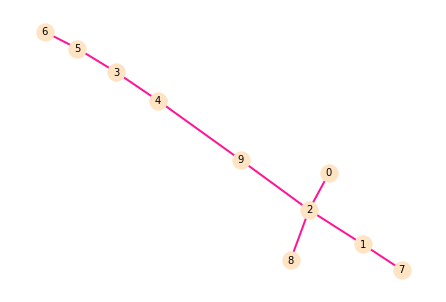

this is A_dict: 
{'1_2': [['t', 't'], ['c', 't'], ['a', 'a'], ['a', 'c'], ['t', 'g']], '1_7': [['t', 't'], ['-', 'a'], ['c', 't'], ['a', 'c'], ['a', 'g'], ['t', 't']], '2_9': [['t', 'a'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['g', 'a']], '2_8': [['t', 't'], ['t', 'g'], ['a', 'g'], ['c', 'c'], ['g', 'c']], '0_2': [['-', 'g'], ['-', 't'], ['t', 't'], ['t', 't'], ['-', 'g'], ['-', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g']], '4_9': [['a', 'a'], ['t', 'c'], ['a', 'g'], ['c', 'c'], ['a', 'a']], '3_4': [['a', 'a'], ['c', 'a'], ['g', 'g'], ['-', 't'], ['c', 't'], ['-', 'a'], ['a', 'a']], '3_5': [['a', 'a'], ['-', 'g'], ['a', 'a'], ['g', 'g'], ['t', 'a'], ['t', 'c'], ['a', 'a'], ['-', 'g'], ['a', 'g']], '5_6': [['a', 'g'], ['g', 'g'], ['a', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'a'], ['a', 't'], ['g', 'c'], ['g', 'g']]}
Total cost of MSA:1220


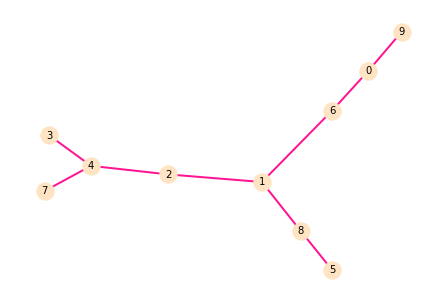

this is A_dict: 
{'1_6': [['c', 'c'], ['c', 'c'], ['g', 'a'], ['g', 'a'], ['g', 'a']], '1_2': [['-', 'g'], ['c', 'a'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g']], '1_8': [['c', 'c'], ['c', 'a'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['g', 'c']], '0_6': [['c', 't'], ['-', 'g'], ['c', 't'], ['a', 't'], ['a', 't'], ['a', 'a']], '2_4': [['g', 'a'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['-', 'c'], ['g', 'g'], ['g', 'g'], ['-', 't']], '5_8': [['c', 'g'], ['a', 'a'], ['g', 'g'], ['-', 'a'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['-', 'a']], '0_9': [['t', '-'], ['g', 'g'], ['t', 't'], ['t', 'c'], ['t', 'c'], ['a', 't']], '3_4': [['-', 'a'], ['a', 'a'], ['a', 'a'], ['t', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'c'], ['g', 't'], ['t', 't']], '4_7': [['a', 'a'], ['a', 't'], ['t', 't'], ['g', 'g'], ['c', 'a'], ['g', 'a'], ['g', 'g'], ['-', 'c'], ['t', 't']]}
Total cost of MSA:1277


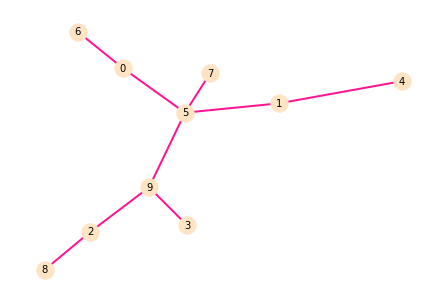

this is A_dict: 
{'0_5': [['g', '-'], ['g', 'g'], ['c', 'c'], ['c', 'g'], ['c', 'a'], ['c', 'c']], '0_6': [['-', 'g'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['-', 'g'], ['c', 'c'], ['c', 't']], '5_9': [['g', 'c'], ['c', 't'], ['g', 'g'], ['-', 't'], ['a', 'a'], ['c', 'c']], '1_5': [['g', 'a'], ['c', '-'], ['g', 'a'], ['a', 'a'], ['c', 'c'], ['-', 'g']], '5_7': [['-', 't'], ['g', 'a'], ['-', 'c'], ['-', 't'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['c', 'c']], '2_9': [['-', 'g'], ['c', 'c'], ['t', 't'], ['-', 'c'], ['g', 'a'], ['t', 't'], ['a', 'g'], ['c', 't']], '3_9': [['c', 't'], ['t', 't'], ['-', 'g'], ['g', 'g'], ['t', 'c'], ['a', 'g'], ['-', 't'], ['c', 'c']], '1_4': [['a', 'g'], ['a', 'a'], ['a', 'g'], ['c', 'c'], ['g', 'g']], '2_8': [['g', 'g'], ['c', 'c'], ['t', 't'], ['c', '-'], ['a', 'a'], ['t', 'a'], ['g', 'g'], ['t', 'g']]}
Total cost of MSA:1272


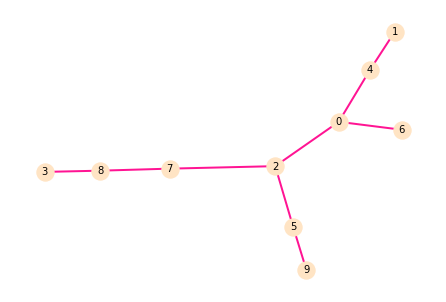

this is A_dict: 
{'0_6': [['g', 'a'], ['c', 't'], ['g', 'g'], ['t', '-'], ['c', '-'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't']], '0_2': [['a', 't'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['c', 't'], ['t', 'a'], ['t', 'c']], '0_4': [['-', 'a'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 't'], ['t', 'a'], ['t', 'g']], '2_7': [['t', 't'], ['t', 'c'], ['a', '-'], ['c', 'c'], ['t', 't'], ['a', 'g'], ['c', 'c']], '2_5': [['t', '-'], ['t', 't'], ['a', 'a'], ['c', 't'], ['t', 't'], ['a', 'a'], ['c', '-']], '1_4': [['a', 'g'], ['a', 'g'], ['t', 't'], ['g', '-'], ['c', 't'], ['t', 'g'], ['a', 'g'], ['g', 'g']], '7_8': [['-', 'g'], ['t', 't'], ['c', 'c'], ['-', 't'], ['c', 't'], ['t', 't'], ['-', 'g'], ['g', 'g'], ['c', 't']], '5_9': [['t', 'a'], ['a', 'g'], ['t', 'a'], ['t', 'a'], ['a', 'a']], '3_8': [['g', '-'], ['t', 't'], ['c', 'c'], ['t', 't'], ['t', 'a'], ['t', 'a'], ['g', 'g'], ['g', 'g'], ['t', 'a']]}
Total cost of MSA:1210


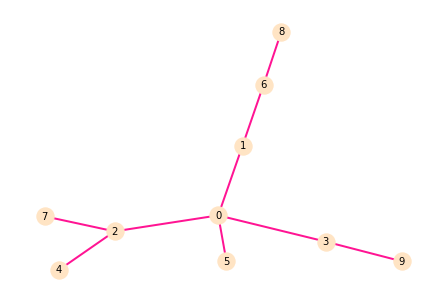

this is A_dict: 
{'2_4': [['c', 't'], ['t', 't'], ['t', 'c'], ['g', '-'], ['c', 'c'], ['g', 'g'], ['g', 'a'], ['g', 'g'], ['a', 'c']], '0_2': [['t', 'g'], ['t', 't'], ['c', 'a'], ['c', 'c'], ['g', '-'], ['a', 'a'], ['g', 'g'], ['c', 't']], '2_7': [['t', 't'], ['-', 'c'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 't'], ['a', 't'], ['g', 'a'], ['c', 't']], '0_3': [['g', 'a'], ['t', 't'], ['a', '-'], ['c', 'c'], ['a', 'a'], ['g', 't'], ['t', 't']], '0_1': [['g', 'g'], ['t', 'c'], ['a', '-'], ['c', 't'], ['a', 't'], ['g', 'g'], ['t', 't']], '0_5': [['g', '-'], ['t', 't'], ['a', 'g'], ['c', 't'], ['a', 'g'], ['g', 'g'], ['t', 'a']], '3_9': [['a', 'a'], ['t', 't'], ['c', 'a'], ['a', 'g'], ['t', 't'], ['-', 'c'], ['t', 'c']], '1_6': [['g', 'a'], ['c', 'g'], ['t', 'c'], ['t', 't'], ['g', 'g'], ['t', '-']], '6_8': [['a', 'c'], ['g', 'g'], ['c', 'a'], ['t', 'c'], ['g', 'g']]}
Total cost of MSA:1168


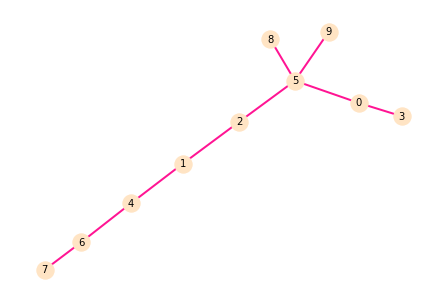

this is A_dict: 
{'0_3': [['t', 't'], ['c', '-'], ['c', '-'], ['a', 'a'], ['a', 'a'], ['a', 'c'], ['a', 'c'], ['t', 't'], ['c', 'c']], '0_5': [['t', '-'], ['a', 'a'], ['a', 'a'], ['c', '-'], ['c', 'c'], ['t', 't'], ['c', 't']], '5_9': [['a', 't'], ['a', 'a'], ['c', 'c'], ['-', 'g'], ['t', 't'], ['t', 't']], '2_5': [['-', 'g'], ['a', 'g'], ['a', 'g'], ['c', 'c'], ['t', 'g'], ['t', 't']], '5_8': [['a', 'g'], ['a', 'g'], ['c', 'c'], ['-', 't'], ['-', 't'], ['t', 't'], ['t', 't']], '1_2': [['g', 't'], ['g', 'g'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['t', '-']], '1_4': [['t', 't'], ['g', 'c'], ['a', 'c'], ['c', 't'], ['g', 'g']], '4_6': [['t', 't'], ['c', 'c'], ['c', 'c'], ['-', 't'], ['-', 'a'], ['t', 't'], ['g', 'g']], '6_7': [['t', 't'], ['c', 'c'], ['-', 'g'], ['c', 't'], ['t', 't'], ['a', 'g'], ['t', 't'], ['g', 'a'], ['-', 't']]}
Total cost of MSA:1233


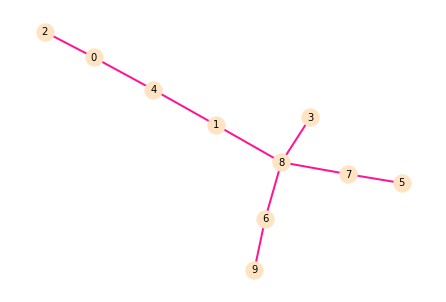

this is A_dict: 
{'0_2': [['g', 't'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['g', '-'], ['c', 'c'], ['c', 'c'], ['g', 'a']], '0_4': [['g', 'a'], ['a', 'a'], ['a', 't'], ['a', 'a'], ['g', 'g'], ['c', 't'], ['c', 'c'], ['g', 'g'], ['-', 't']], '1_4': [['a', '-'], ['a', 'a'], ['t', '-'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['c', '-'], ['g', 'g'], ['t', 't']], '1_8': [['-', 'c'], ['a', 'c'], ['a', 'a'], ['g', 't'], ['t', 'c'], ['g', 'g'], ['t', 't']], '3_8': [['c', 'c'], ['c', 'c'], ['a', 'g'], ['-', 'c'], ['t', 'c'], ['-', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't']], '6_8': [['c', 'a'], ['c', 'c'], ['a', '-'], ['t', 't'], ['c', 'c'], ['g', 't'], ['t', 'c']], '7_8': [['c', 't'], ['-', 'a'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['-', 'a'], ['c', 'a'], ['g', 'g'], ['t', 'c']], '6_9': [['-', 'c'], ['a', 'a'], ['-', 't'], ['c', 'c'], ['t', 'c'], ['c', 'c'], ['t', 'c'], ['c', 'c']], '5_7': [['t', '-'], ['a', 'a'], ['c', 'c'], ['a', 'c'], ['t', 'a'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'g']]}
T

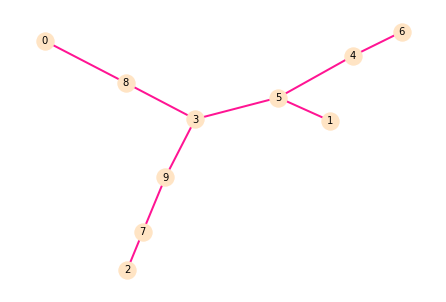

this is A_dict: 
{'2_7': [['g', '-'], ['g', 'g'], ['t', '-'], ['t', 'c'], ['t', 'g'], ['t', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g']], '7_9': [['g', 'g'], ['c', 't'], ['g', 'a'], ['c', 't'], ['t', 't'], ['c', 't'], ['g', '-']], '3_9': [['g', '-'], ['t', 'c'], ['a', 'a'], ['t', 'c'], ['t', 'c'], ['t', 'c']], '3_8': [['c', 'a'], ['a', 'g'], ['c', 'c'], ['c', 'c'], ['-', 'g'], ['c', 'c']], '3_5': [['-', 't'], ['-', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'a'], ['c', 'c']], '0_8': [['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['-', 'g'], ['g', 'g'], ['c', 'c']], '4_5': [['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'g'], ['a', 't'], ['c', 'c']], '1_5': [['t', 't'], ['c', 't'], ['c', 't'], ['a', 'a'], ['c', '-'], ['a', 'a'], ['c', 'g']], '4_6': [['t', 't'], ['c', 'c'], ['-', 'a'], ['-', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['t', 'c'], ['c', 'a']]}
Total cost of MSA:1185


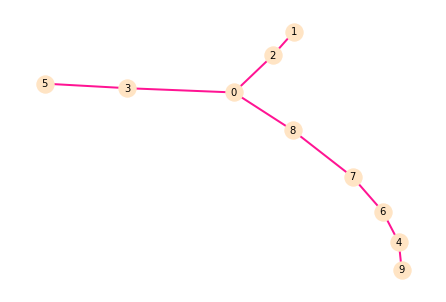

this is A_dict: 
{'1_2': [['g', '-'], ['a', '-'], ['g', 'g'], ['a', 'a'], ['c', '-'], ['g', '-'], ['c', 'c'], ['t', 't'], ['g', 'a']], '0_2': [['-', 'c'], ['g', 'g'], ['a', 'g'], ['c', 'a'], ['t', 't'], ['a', 'a']], '0_8': [['c', 'c'], ['g', '-'], ['g', 'a'], ['a', 'a'], ['t', 't'], ['-', 'g'], ['a', 'a']], '0_3': [['-', 't'], ['c', 'c'], ['-', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['a', 'g']], '7_8': [['c', 'c'], ['a', 'g'], ['a', 'a'], ['t', 't'], ['-', 'c'], ['g', 'g'], ['a', 'a']], '3_5': [['-', 'a'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'g'], ['g', 'c']], '6_7': [['c', 'c'], ['-', 't'], ['g', 'a'], ['a', 'g'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['a', 'c']], '4_6': [['c', 'c'], ['t', 't'], ['a', 'a'], ['g', 'c'], ['t', 'c'], ['c', 't'], ['g', 't'], ['c', 't']], '4_9': [['c', '-'], ['t', 't'], ['a', '-'], ['c', 'c'], ['c', 't'], ['t', 't'], ['t', 't'], ['t', 'c']]}
Total cost of MSA:1339


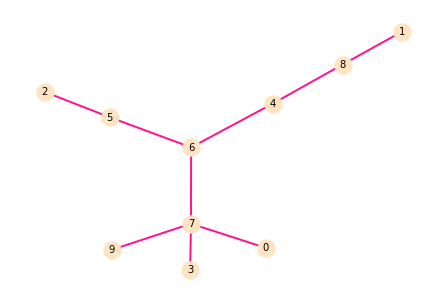

this is A_dict: 
{'2_5': [['a', '-'], ['t', '-'], ['a', '-'], ['a', 'g'], ['a', 'g'], ['g', 'g'], ['g', 'a'], ['g', 'g']], '5_6': [['-', 'c'], ['g', 'g'], ['g', 't'], ['g', 'c'], ['a', 'g'], ['g', 'a']], '6_7': [['-', 'g'], ['c', 'c'], ['g', 'c'], ['t', 'c'], ['c', 't'], ['g', 'g'], ['a', 'a']], '4_6': [['c', 't'], ['g', 'g'], ['-', 'a'], ['t', 't'], ['c', 't'], ['g', 't'], ['a', 'g']], '7_9': [['g', 'a'], ['c', 't'], ['c', 't'], ['c', 't'], ['t', 'c'], ['g', 'g'], ['-', 'c'], ['a', 'a']], '0_7': [['g', 'g'], ['c', 'c'], ['c', 't'], ['-', 'g'], ['c', 'c'], ['t', 't'], ['g', '-'], ['a', '-']], '3_7': [['g', 't'], ['c', 't'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['-', 'c'], ['-', 'a'], ['g', 'g'], ['a', 'g']], '4_8': [['t', 'c'], ['g', 'g'], ['-', 't'], ['a', 'g'], ['t', 'c'], ['t', 't'], ['t', 'c'], ['g', 't']], '1_8': [['c', 'c'], ['g', 't'], ['t', 't'], ['g', 'g'], ['c', 't'], ['t', 'a'], ['c', 'a'], ['t', 't']]}
Total cost of MSA:1349


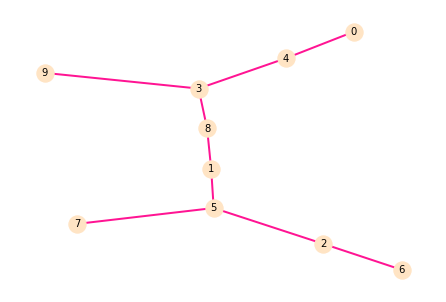

this is A_dict: 
{'0_4': [['a', 'a'], ['t', 't'], ['a', 'g'], ['t', 'g'], ['a', 'a'], ['c', 'a'], ['c', 'c'], ['c', 'c'], ['t', '-']], '3_4': [['a', 'g'], ['t', 'c'], ['a', 'g'], ['t', 'c'], ['a', '-'], ['c', 'c'], ['c', 'c'], ['c', 'a'], ['t', 't']], '3_9': [['g', 'g'], ['c', 'c'], ['-', 'g'], ['g', 'g'], ['c', 't'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['t', '-']], '3_8': [['g', 'a'], ['c', 'c'], ['g', 'a'], ['c', '-'], ['c', 'c'], ['c', 't'], ['a', 'a'], ['t', 'a']], '1_8': [['a', 'c'], ['c', 'c'], ['a', 'a'], ['-', 'c'], ['c', 'c'], ['t', 't'], ['a', 'c'], ['a', 'a']], '1_5': [['c', 't'], ['c', 't'], ['a', 'a'], ['c', '-'], ['c', '-'], ['t', 't'], ['c', 'c'], ['a', 'g']], '2_5': [['t', 'c'], ['t', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['g', '-']], '5_7': [['-', 't'], ['t', 't'], ['t', 't'], ['a', 'g'], ['t', 'a'], ['c', 'a'], ['g', 'g']], '2_6': [['c', 'a'], ['g', 't'], ['a', 't'], ['t', 't'], ['c', 'c']]}
Total cost of MSA:1161


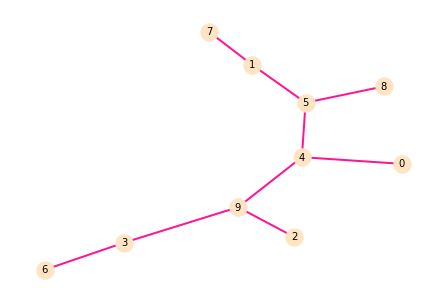

this is A_dict: 
{'2_9': [['g', 'a'], ['t', 'c'], ['t', 'g'], ['t', 't'], ['t', 'g'], ['t', 't'], ['a', 'g']], '3_9': [['a', 'a'], ['c', 'c'], ['g', 'a'], ['t', 't'], ['g', '-'], ['t', 't'], ['g', '-']], '4_9': [['-', 't'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['t', 't'], ['g', 'a'], ['t', 't'], ['g', 't']], '3_6': [['a', 'c'], ['c', 'c'], ['-', 't'], ['a', 'g'], ['t', 'c'], ['t', 't']], '4_5': [['t', 'c'], ['a', 'a'], ['t', 'g'], ['g', 'g'], ['t', 't'], ['a', 't'], ['t', 'c'], ['t', 't']], '0_4': [['t', 'c'], ['a', 'g'], ['-', 't'], ['t', 't'], ['g', 'a'], ['t', 'c'], ['a', 'a'], ['t', 'g'], ['t', 't']], '1_5': [['c', 't'], ['a', 't'], ['g', 'a'], ['g', 'g'], ['t', 'c'], ['t', 't'], ['c', 'g'], ['t', 'c']], '5_8': [['c', 'g'], ['a', 'g'], ['g', 'g'], ['-', 'a'], ['g', 'a'], ['t', 'g'], ['t', 'a'], ['c', 'c'], ['t', 't']], '1_7': [['t', 't'], ['t', 'g'], ['a', 'g'], ['g', 'a'], ['c', 'c'], ['t', 't'], ['g', 'a'], ['c', '-']]}
Total cost of MSA:1175


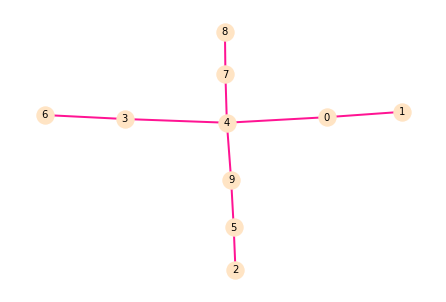

this is A_dict: 
{'0_1': [['c', 'c'], ['a', 'a'], ['a', 'a'], ['t', 'g'], ['c', 'c'], ['c', 't'], ['a', 't'], ['a', 't']], '0_4': [['c', '-'], ['a', '-'], ['a', '-'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't']], '4_9': [['-', 't'], ['g', 'a'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 'a']], '3_4': [['g', 'g'], ['c', 'c'], ['t', 'c'], ['-', 'a'], ['t', 'g'], ['t', 'c']], '4_7': [['g', 'g'], ['c', 'g'], ['t', 't'], ['-', 'g'], ['t', 't'], ['-', 'a'], ['t', 't']], '5_9': [['t', 't'], ['-', 'c'], ['a', 'g'], ['c', 'c'], ['t', 't'], ['t', 'a'], ['a', 'g']], '3_6': [['g', 'c'], ['c', 't'], ['c', 't'], ['a', 'a'], ['g', 'a'], ['-', 'c'], ['c', 'c']], '7_8': [['g', 'g'], ['g', 'a'], ['t', '-'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', '-']], '2_5': [['t', 'c'], ['c', 't'], ['g', 'a'], ['c', '-'], ['t', 't'], ['a', 'a'], ['g', 'g']]}
Total cost of MSA:1208


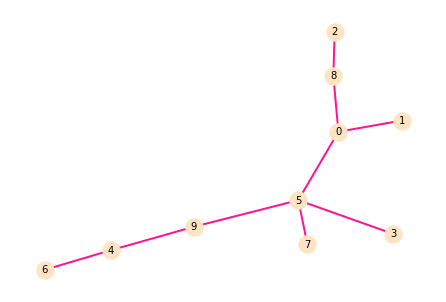

this is A_dict: 
{'3_5': [['t', 't'], ['a', 'c'], ['a', 'a'], ['g', 'a'], ['a', 'a']], '0_5': [['t', 'a'], ['c', 'c'], ['a', 'g'], ['-', 'c'], ['a', 'a'], ['a', 'a']], '5_9': [['t', 't'], ['c', 't'], ['a', 'a'], ['a', 't'], ['a', 't']], '5_7': [['-', 't'], ['t', 't'], ['c', 't'], ['a', 'a'], ['a', 'a'], ['a', 'g'], ['-', 't']], '0_8': [['a', 'a'], ['c', 't'], ['-', 'g'], ['g', 'g'], ['c', 't'], ['a', 'c'], ['a', 'g']], '0_1': [['a', 'g'], ['c', 'a'], ['g', 'g'], ['c', 't'], ['a', 'a'], ['-', 'c'], ['a', 'c']], '4_9': [['-', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['-', 't'], ['t', 't'], ['t', 't'], ['-', 'c']], '2_8': [['a', 'a'], ['t', 't'], ['g', 't'], ['g', 'g'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['-', 't'], ['-', 'a']], '4_6': [['g', 'a'], ['t', 'c'], ['t', 'c'], ['a', 'a'], ['t', 'a'], ['t', 't'], ['t', 'a'], ['c', 'c']]}
Total cost of MSA:1149


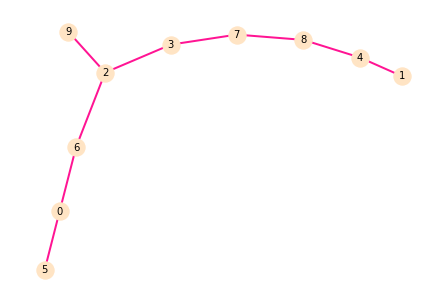

this is A_dict: 
{'1_4': [['g', 't'], ['g', 'g'], ['a', 'c'], ['a', 't'], ['a', 'g'], ['g', 'g'], ['a', 'g'], ['c', 'c']], '4_8': [['t', 't'], ['g', 'g'], ['c', '-'], ['t', '-'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['-', 't']], '7_8': [['t', 'c'], ['g', 'a'], ['g', 'a'], ['g', 'c'], ['g', 'g'], ['c', 'c'], ['t', 'c']], '3_7': [['c', '-'], ['a', 'g'], ['a', 'g'], ['c', 'c'], ['g', 'g'], ['c', '-'], ['c', 'c']], '2_3': [['g', 'g'], ['g', 'g'], ['c', 't'], ['g', 'g'], ['-', 't'], ['-', 't'], ['c', 't']], '2_6': [['g', 'a'], ['g', 'a'], ['t', 'c'], ['g', 'a'], ['t', 't'], ['t', 't'], ['t', 'g']], '2_9': [['g', 'a'], ['-', 'c'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['t', 'c'], ['t', 't'], ['t', 't'], ['-', 'a']], '0_6': [['a', 'g'], ['a', 't'], ['c', 'c'], ['-', 't'], ['a', 'a'], ['t', 'g'], ['t', 't'], ['g', 'g']], '0_5': [['g', 'g'], ['t', 'g'], ['c', 'c'], ['-', 'g'], ['t', 'c'], ['a', 'a'], ['g', 'a'], ['t', 't'], ['g', 'g']]}
Total cost of MSA:1240


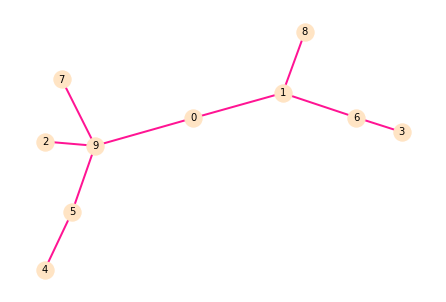

this is A_dict: 
{'3_6': [['c', '-'], ['c', '-'], ['c', 'g'], ['t', 'g'], ['a', 'a'], ['c', 'c'], ['c', 't'], ['c', 'c']], '1_6': [['g', 'a'], ['g', 'g'], ['a', 'g'], ['c', 't'], ['t', 'g'], ['c', 'c']], '0_1': [['a', 't'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['c', 'a']], '1_8': [['a', 'g'], ['g', 't'], ['g', 'g'], ['t', '-'], ['g', 'g'], ['c', 'c']], '0_9': [['t', 't'], ['g', 'a'], ['g', 'a'], ['t', 'a'], ['g', 'g'], ['a', 'a']], '7_9': [['t', 't'], ['a', 't'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['a', '-']], '2_9': [['t', 'g'], ['a', 'a'], ['-', 'c'], ['a', 'a'], ['-', 'c'], ['a', 'g'], ['g', 'a'], ['a', 'a']], '5_9': [['-', 'a'], ['-', 'g'], ['t', 'c'], ['-', 'g'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['a', 'g']], '4_5': [['a', 'a'], ['g', 'g'], ['c', 't'], ['g', 't'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['g', 't'], ['g', 'g']]}
Total cost of MSA:1157


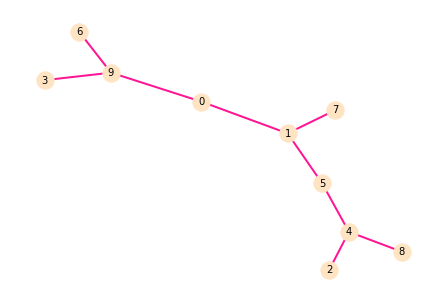

this is A_dict: 
{'4_8': [['t', 't'], ['t', 't'], ['c', 'c'], ['t', 'g'], ['a', 't'], ['a', 'a'], ['g', 't'], ['a', 'a'], ['g', 't']], '2_4': [['t', '-'], ['t', 't'], ['c', 'g'], ['g', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['a', '-'], ['t', 't']], '4_5': [['t', '-'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['t', 'g'], ['a', 'a'], ['-', 'c'], ['t', 't'], ['a', 'a'], ['t', 't']], '1_5': [['c', 'a'], ['c', 'c'], ['g', 'g'], ['g', 'a'], ['a', 'g'], ['c', 'c'], ['t', '-'], ['a', 'g'], ['t', 't']], '0_1': [['a', 'a'], ['c', 'c'], ['g', '-'], ['a', 'a'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['t', '-']], '1_7': [['a', 'a'], ['-', 't'], ['c', 'c'], ['g', 'c'], ['a', 'g'], ['g', 'g'], ['c', 'c'], ['g', 't'], ['t', 'c']], '0_9': [['a', 'g'], ['c', 'c'], ['a', '-'], ['a', 'g'], ['c', 'c'], ['g', 'a']], '6_9': [['g', 'g'], ['c', 'c'], ['g', 't'], ['c', 'g'], ['a', 'g']], '3_9': [['-', 'c'], ['g', 't'], ['c', 'c'], ['g', 't'], ['c', 'c'], ['a', 'a']]}
Total cost of MSA:1327


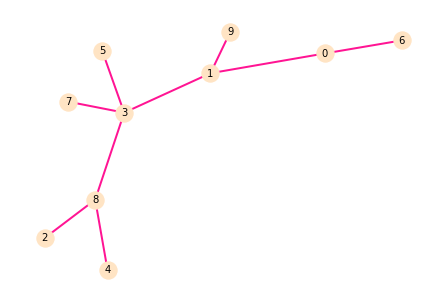

this is A_dict: 
{'3_5': [['t', 't'], ['t', 'a'], ['t', 'c'], ['g', '-'], ['g', 'a'], ['c', 'c']], '1_3': [['t', 't'], ['-', 'g'], ['a', 'g'], ['c', 'c'], ['a', 'c'], ['c', 'c']], '3_8': [['t', 'g'], ['a', 't'], ['c', 'c'], ['a', 'g'], ['c', 't']], '3_7': [['t', 't'], ['a', 'a'], ['c', 'c'], ['-', 't'], ['-', 't'], ['a', 'a'], ['c', 'c'], ['-', 'a']], '0_1': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'g']], '1_9': [['t', 'g'], ['g', 'a'], ['g', 'a'], ['c', 'c'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['-', 't'], ['-', 't']], '4_8': [['g', 'c'], ['t', 't'], ['c', 't'], ['g', 'c'], ['t', 't']], '2_8': [['g', 'a'], ['t', 't'], ['c', 'a'], ['g', 'a'], ['t', 'g']], '0_6': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 't'], ['c', 'g'], ['g', 'g']]}
Total cost of MSA:1034


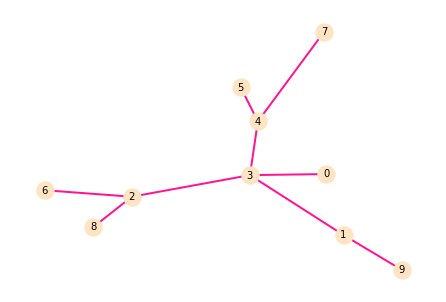

this is A_dict: 
{'4_5': [['c', 'c'], ['t', '-'], ['a', 'a'], ['g', 'a'], ['g', 'g'], ['a', '-'], ['g', 'c']], '4_7': [['c', 'c'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c']], '3_4': [['c', 'a'], ['a', 'c'], ['a', 'c'], ['g', 'g'], ['c', 'c']], '1_3': [['a', 'g'], ['c', 't'], ['c', 'c'], ['g', 'a'], ['c', 'c']], '2_3': [['-', 'a'], ['a', 'a'], ['c', 'c'], ['-', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c']], '0_3': [['-', 'g'], ['a', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['c', '-']], '1_9': [['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['-', 'c'], ['c', 'c'], ['-', 't']], '2_6': [['a', 'c'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'a'], ['c', '-']], '2_8': [['-', 'g'], ['a', 'g'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'c'], ['c', 'c'], ['-', 't']]}
Total cost of MSA:1062


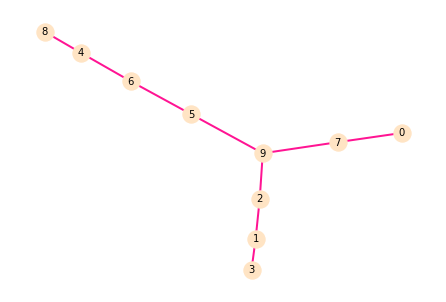

this is A_dict: 
{'0_7': [['t', 'a'], ['c', 'c'], ['t', 'c'], ['c', 'c'], ['t', 't'], ['c', '-'], ['c', 't'], ['c', 't'], ['a', 'a']], '7_9': [['a', 'a'], ['c', 't'], ['c', 'g'], ['c', 'c'], ['t', '-'], ['t', '-'], ['t', 't'], ['a', 'a']], '5_9': [['a', 'g'], ['t', 'c'], ['g', 'g'], ['c', 'c'], ['t', '-'], ['a', 'g']], '2_9': [['-', 'a'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', '-'], ['t', 't'], ['a', '-']], '5_6': [['g', 't'], ['c', 't'], ['g', 'a'], ['c', 'g'], ['g', 'g']], '1_2': [['a', 'c'], ['a', 't'], ['t', 't'], ['g', 'g'], ['t', 't'], ['-', 'c']], '4_6': [['t', 't'], ['-', 'c'], ['-', 'a'], ['t', 't'], ['-', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'a']], '1_3': [['c', 'c'], ['t', 'c'], ['-', 'a'], ['-', 'a'], ['t', 't'], ['g', 'g'], ['t', 'c'], ['-', 'g'], ['c', 'c']], '4_8': [['-', 'g'], ['t', 'g'], ['c', 'g'], ['a', 'g'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['g', 'a'], ['a', 't']]}
Total cost of MSA:1459


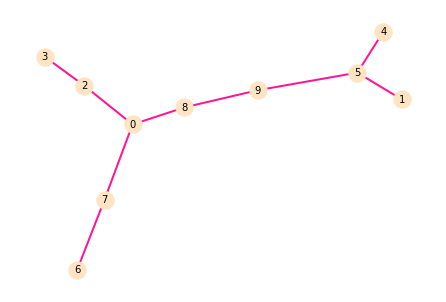

this is A_dict: 
{'1_5': [['c', 't'], ['g', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['c', '-']], '5_9': [['t', 't'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['g', 'a'], ['a', 'g']], '4_5': [['t', 'c'], ['t', 't'], ['g', 'g'], ['-', 'c'], ['a', 'g'], ['-', 'c'], ['g', 'g'], ['a', 'g']], '8_9': [['t', 'a'], ['t', 't'], ['g', 'a'], ['a', 'g'], ['a', 'a'], ['g', 'g']], '0_8': [['a', 'a'], ['-', 'g'], ['t', 't'], ['a', 't'], ['g', 'c'], ['a', 'a'], ['g', '-']], '0_7': [['-', 't'], ['a', 'a'], ['g', 'c'], ['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a']], '0_2': [['-', 'g'], ['a', 'a'], ['g', 'g'], ['t', 'c'], ['t', 't'], ['c', 't'], ['a', '-']], '6_7': [['t', 't'], ['a', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['c', 't'], ['a', 'a']], '2_3': [['g', 'c'], ['a', 'a'], ['g', '-'], ['c', 'c'], ['t', 'c'], ['t', 'c']]}
Total cost of MSA:1161


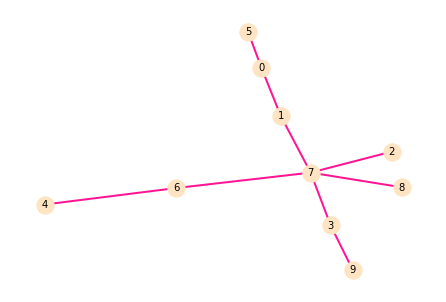

this is A_dict: 
{'4_6': [['g', '-'], ['t', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'a'], ['c', 'c']], '6_7': [['c', 'c'], ['c', 'c'], ['c', 'a'], ['a', 'a'], ['g', 't'], ['a', 'a'], ['c', '-']], '1_7': [['c', '-'], ['c', 'c'], ['a', 'g'], ['a', 'c'], ['t', 'c'], ['a', 'g']], '3_7': [['c', 't'], ['-', 'g'], ['c', 'c'], ['a', 't'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['-', 'g']], '2_7': [['c', 'a'], ['c', 't'], ['a', 'a'], ['a', 'g'], ['t', 't'], ['a', 'a'], ['-', 'c'], ['-', 't']], '7_8': [['c', 'c'], ['c', 'c'], ['a', 'g'], ['a', 'g'], ['-', 'c'], ['-', 't'], ['-', 'c'], ['t', 't'], ['a', 'a']], '0_1': [['c', 'a'], ['g', 'a'], ['-', 't'], ['c', 'c'], ['c', 'c'], ['-', 'a'], ['g', 'g']], '3_9': [['t', 'c'], ['-', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['t', 'g'], ['a', 'a'], ['g', 'a']], '0_5': [['-', 't'], ['a', 'g'], ['-', 't'], ['a', 'a'], ['t', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['g', 't']]}
Total cost of MSA:1482


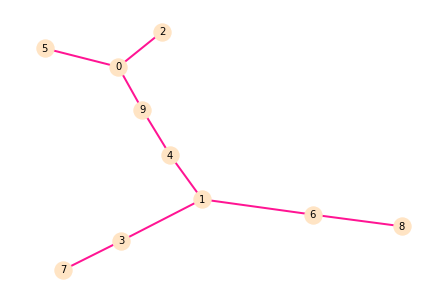

this is A_dict: 
{'0_2': [['t', 'c'], ['a', 'a'], ['a', 'g'], ['c', 't'], ['c', 't'], ['g', '-'], ['g', 'g']], '0_9': [['-', 'g'], ['-', 'g'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['c', '-'], ['c', 'c'], ['g', 'g'], ['g', 'g']], '0_5': [['t', 't'], ['a', 'g'], ['a', 'a'], ['c', 'a'], ['c', 'a'], ['g', 'a'], ['g', 't']], '4_9': [['g', 'c'], ['g', 'g'], ['t', 'c'], ['g', 'a'], ['a', 'g'], ['c', 't'], ['g', 'g'], ['g', 'a']], '1_4': [['c', '-'], ['g', 'g'], ['c', 'c'], ['a', 't'], ['g', 'a'], ['t', 't'], ['g', '-'], ['a', 'a']], '1_3': [['g', 'a'], ['c', '-'], ['t', 't'], ['a', 'g'], ['t', 'c'], ['a', 'a']], '1_6': [['g', 'a'], ['-', 'c'], ['c', 'c'], ['t', 't'], ['-', 'g'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['-', 't']], '3_7': [['a', 'a'], ['t', 't'], ['g', 'c'], ['c', 'a'], ['a', 'a'], ['-', 'c']], '6_8': [['a', 't'], ['c', 'c'], ['c', 'c'], ['-', 't'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['t', 't'], ['a', 'g'], ['t', '-']]}
Total cost of MSA:1295


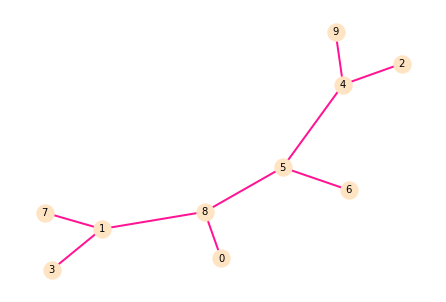

this is A_dict: 
{'2_4': [['t', 'a'], ['c', 'c'], ['c', 'g'], ['t', 't'], ['-', 'g'], ['t', 't']], '4_5': [['a', 'a'], ['c', '-'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['t', 'c']], '4_9': [['a', 'a'], ['-', 'c'], ['c', 'c'], ['g', 'g'], ['t', 'g'], ['g', 'g'], ['t', 'c']], '5_6': [['a', 'g'], ['g', 'a'], ['t', 't'], ['-', 'c'], ['g', 'a'], ['c', 'c']], '5_8': [['a', 'a'], ['g', 'g'], ['t', 'g'], ['g', 'g'], ['-', 't'], ['c', 'c'], ['-', 'a']], '1_8': [['-', 'c'], ['a', 'g'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'g']], '0_8': [['a', 'g'], ['-', 't'], ['g', 'g'], ['g', 'g'], ['g', 'a'], ['t', 't'], ['-', 'c'], ['c', 'c'], ['a', 'a']], '1_3': [['c', 'c'], ['-', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['t', 'c'], ['c', 'g'], ['g', 'g']], '1_7': [['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'a'], ['-', 't'], ['g', 'a'], ['t', 'g'], ['c', 't'], ['g', 'a']]}
Total cost of MSA:1214


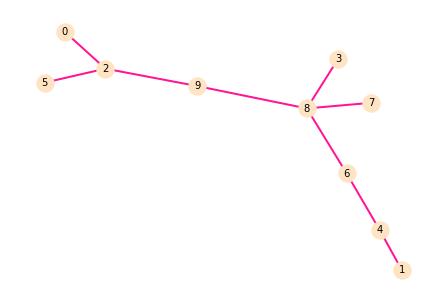

this is A_dict: 
{'4_6': [['a', 'a'], ['t', '-'], ['t', 't'], ['c', 'c'], ['t', '-'], ['t', 'c'], ['t', 't']], '1_4': [['a', 'g'], ['t', 'g'], ['t', 't'], ['c', 'c'], ['-', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['-', 'c']], '6_8': [['a', 'a'], ['t', 'a'], ['c', 'c'], ['c', 't'], ['t', 'g']], '8_9': [['a', 'g'], ['a', 'a'], ['c', 't'], ['t', 'a'], ['g', 'a']], '3_8': [['a', 'a'], ['a', 'a'], ['c', 't'], ['t', 't'], ['g', 'g'], ['-', 't'], ['-', 'a']], '7_8': [['-', 'c'], ['a', 'g'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['-', 'c'], ['g', 'a'], ['-', 'c']], '2_9': [['g', 'g'], ['-', 't'], ['a', 'c'], ['t', 't'], ['-', 'a'], ['a', 'a'], ['a', 'a']], '0_2': [['g', 'g'], ['-', 'a'], ['t', 't'], ['-', 'a'], ['c', 'c'], ['t', 'g'], ['a', 'a'], ['a', 'a'], ['a', 'g']], '2_5': [['g', '-'], ['t', 't'], ['c', 'c'], ['-', 'g'], ['-', 'a'], ['t', 'g'], ['a', 'a'], ['a', 'a'], ['a', 'a']]}
Total cost of MSA:1367


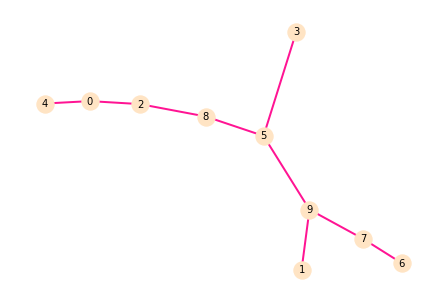

this is A_dict: 
{'0_4': [['g', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'a'], ['t', '-'], ['t', 'g'], ['a', 'a'], ['g', 'a']], '0_2': [['g', '-'], ['g', 't'], ['g', 'g'], ['g', 'a'], ['t', 'c'], ['t', 't'], ['a', 'g'], ['g', 'a']], '2_8': [['t', 'c'], ['g', '-'], ['a', 'a'], ['c', 'c'], ['t', '-'], ['g', 'g'], ['a', 'a']], '5_8': [['-', 'g'], ['c', 't'], ['a', 'a'], ['c', 'c'], ['g', '-'], ['a', 'c']], '3_5': [['g', 'g'], ['t', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c']], '5_9': [['g', 'g'], ['-', 't'], ['t', 't'], ['-', 'g'], ['a', 'a'], ['c', 't'], ['c', 't']], '7_9': [['g', 'g'], ['t', 'c'], ['t', 'c'], ['-', 'a'], ['g', 'g'], ['a', 'g'], ['t', 't'], ['-', 'c'], ['t', 't']], '1_9': [['-', 'a'], ['-', 'a'], ['g', 'a'], ['t', 'c'], ['t', 't'], ['g', 'g'], ['a', 't'], ['t', 'c'], ['t', 't']], '6_7': [['g', '-'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['g', 't'], ['g', 'g'], ['t', 'c'], ['-', 'g'], ['c', 'c'], ['t', 'c']]}
Total cost of MSA:1323


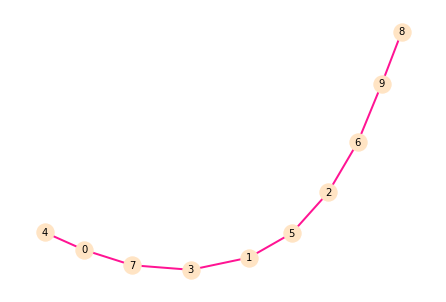

this is A_dict: 
{'6_9': [['a', 'a'], ['g', '-'], ['g', 'a'], ['t', '-'], ['c', 'c'], ['g', 'a'], ['a', 'a'], ['a', 'a']], '2_6': [['a', 'a'], ['-', 't'], ['g', 'g'], ['g', 'a'], ['t', 'c'], ['c', 'c'], ['g', 'a'], ['a', 't'], ['a', 'g']], '8_9': [['-', 't'], ['a', 'a'], ['-', 'g'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['a', 'g'], ['a', 'a']], '2_5': [['-', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['c', 'g'], ['c', 't'], ['a', '-'], ['t', 't'], ['g', 'a']], '1_5': [['-', 't'], ['g', 'g'], ['a', 'c'], ['t', 't'], ['g', 'g'], ['a', '-'], ['g', 'g'], ['t', 't'], ['t', 't'], ['a', '-']], '1_3': [['t', 't'], ['g', '-'], ['c', 'c'], ['t', '-'], ['g', 'g'], ['g', 'a'], ['t', 't'], ['t', 't']], '3_7': [['t', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['-', 'g'], ['t', 'c'], ['t', 'c']], '0_7': [['c', '-'], ['c', 'c'], ['g', 'a'], ['a', 'g'], ['g', 'c'], ['c', 'c'], ['c', 'c']], '0_4': [['c', 't'], ['a', 't'], ['g', 'g'], ['c', 't'], ['c', 'c'], ['c', 'a']]}
Total cost of MSA:1470


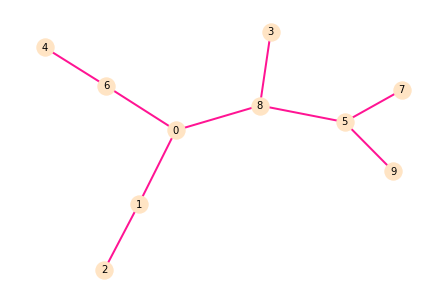

this is A_dict: 
{'4_6': [['g', 'g'], ['a', '-'], ['g', 'g'], ['g', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['-', 'g']], '0_6': [['g', '-'], ['g', '-'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['c', 'a'], ['g', 'g']], '0_1': [['a', 'c'], ['g', 'a'], ['t', 't'], ['a', 't'], ['g', 'c']], '0_8': [['a', 'a'], ['-', 'c'], ['g', 'g'], ['-', 'c'], ['t', 'c'], ['a', 'a'], ['g', 'g'], ['-', 't']], '1_2': [['c', 't'], ['a', 'a'], ['t', 't'], ['-', 'c'], ['-', 'c'], ['t', 'c'], ['c', 'c']], '3_8': [['-', 'a'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['c', 'g'], ['c', 't'], ['a', 'a'], ['g', 'g'], ['t', 't']], '5_8': [['a', 'a'], ['c', 'c'], ['g', 'a'], ['c', 't'], ['-', 'a'], ['c', 't'], ['a', 'c'], ['g', 'g'], ['t', 't']], '5_9': [['a', '-'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['-', 'a'], ['g', 'g'], ['t', 'g']], '5_7': [['a', 'g'], ['c', 'c'], ['a', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', '-'], ['g', 'a'], ['t', 'a']]}
Total cost of MSA:1390


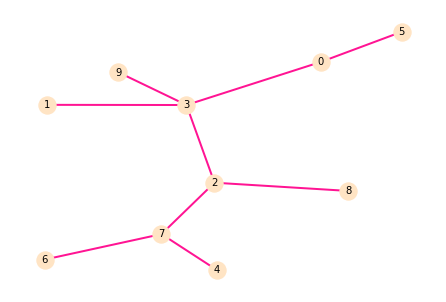

this is A_dict: 
{'1_3': [['c', '-'], ['c', 'c'], ['t', '-'], ['t', '-'], ['g', 'g'], ['g', 'g'], ['t', 'c'], ['t', 't'], ['a', 'g']], '2_3': [['c', 'c'], ['g', 'g'], ['g', 'a'], ['c', 'c'], ['t', 't'], ['g', 'c']], '0_3': [['c', 'c'], ['g', '-'], ['g', 't'], ['c', 't'], ['t', 't'], ['g', 'g']], '3_9': [['c', 't'], ['g', 'g'], ['g', 'a'], ['c', 'c'], ['t', 'c'], ['-', 'a'], ['-', 'g'], ['g', 'g']], '2_7': [['c', 'c'], ['g', 'g'], ['-', 'a'], ['a', 'a'], ['c', 'c'], ['-', 'g'], ['t', 'a'], ['c', 'c']], '2_8': [['c', 't'], ['g', 'g'], ['-', 't'], ['-', 'a'], ['a', 'a'], ['c', 't'], ['t', 'c'], ['c', 'c']], '0_5': [['c', 'c'], ['t', 'c'], ['-', 'g'], ['t', 't'], ['-', 'g'], ['t', 'a'], ['g', 'g']], '4_7': [['c', 'c'], ['g', 't'], ['a', 'a'], ['a', 't'], ['c', 'c'], ['g', 'g'], ['a', 'c'], ['c', 'c']], '6_7': [['c', 'c'], ['g', '-'], ['a', 'a'], ['a', 'c'], ['c', 'c'], ['g', 'g'], ['-', 'a'], ['a', 'a'], ['c', 'c']]}
Total cost of MSA:1236


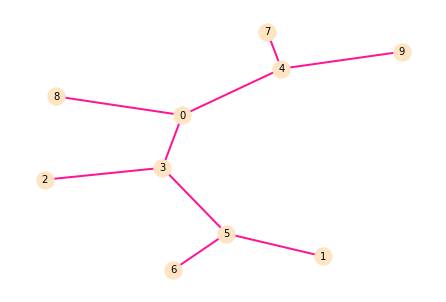

this is A_dict: 
{'1_5': [['a', '-'], ['g', 'g'], ['a', '-'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['-', 'a'], ['c', 'c']], '3_5': [['g', 'g'], ['g', 'g'], ['c', 'c'], ['t', 'c'], ['a', 'a'], ['c', '-']], '5_6': [['-', 't'], ['g', 'g'], ['g', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'a']], '0_3': [['g', 'g'], ['-', 't'], ['g', 'a'], ['c', 'c'], ['c', 'c'], ['-', 't'], ['a', 'g']], '2_3': [['g', 't'], ['g', 'g'], ['c', 't'], ['c', 'g'], ['a', 'g']], '0_8': [['g', 'a'], ['t', 't'], ['-', 'a'], ['a', 'a'], ['c', 't'], ['c', 'c'], ['t', 't'], ['g', 'a']], '0_4': [['g', 'g'], ['t', 'c'], ['a', 'a'], ['c', 'g'], ['c', 'c'], ['t', '-'], ['g', 'g']], '4_7': [['g', 'a'], ['c', 't'], ['a', 'c'], ['g', 'g'], ['c', 'c'], ['g', 't']], '4_9': [['g', 'c'], ['c', 'c'], ['a', 'a'], ['g', '-'], ['c', 't'], ['g', 'a']]}
Total cost of MSA:1008


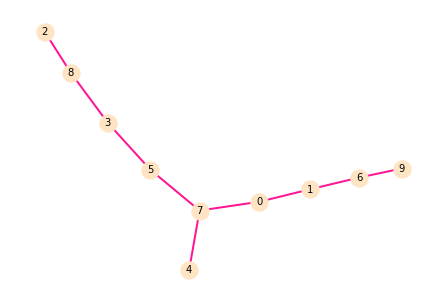

this is A_dict: 
{'0_7': [['c', 'c'], ['t', 't'], ['c', '-'], ['g', 'g'], ['t', '-'], ['g', 'g'], ['g', 't']], '4_7': [['c', 'g'], ['t', 'c'], ['c', 't'], ['g', '-'], ['t', 't'], ['g', 'a'], ['g', 'g']], '5_7': [['c', 't'], ['-', 'a'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['t', 'c'], ['g', 'g'], ['-', 't'], ['g', 'g']], '0_1': [['c', 't'], ['-', 'g'], ['t', 't'], ['g', 'g'], ['-', 'a'], ['g', 'a'], ['t', 't'], ['-', 'c']], '3_5': [['t', 'a'], ['a', 'g'], ['c', 't'], ['c', 't'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', '-']], '1_6': [['t', 'c'], ['g', '-'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['-', 'c'], ['t', 't'], ['-', 'a'], ['c', 'c']], '3_8': [['a', 'a'], ['g', 'g'], ['-', 'a'], ['t', 't'], ['t', 'g'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', '-']], '6_9': [['c', 'a'], ['t', 'c'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['c', 'c'], ['t', 'c'], ['a', 't'], ['c', 'c']], '2_8': [['-', 'g'], ['-', 'a'], ['a', 'a'], ['g', 'a'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['

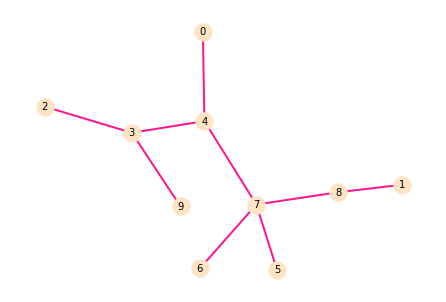

this is A_dict: 
{'0_4': [['c', 'c'], ['t', 't'], ['g', 'g'], ['t', '-'], ['g', 'a'], ['a', 'a'], ['c', '-'], ['g', 'g'], ['g', 'a']], '3_4': [['c', 'c'], ['t', '-'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['g', '-'], ['a', 't']], '4_7': [['c', 't'], ['t', 'c'], ['g', 'c'], ['a', 'c'], ['a', 'a'], ['g', 't'], ['a', 'a']], '2_3': [['-', 'g'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['a', 'g'], ['t', 't']], '3_9': [['c', '-'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['-', 'g']], '6_7': [['t', 'a'], ['c', 'a'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['t', 't'], ['-', 'c'], ['a', 'a']], '7_8': [['-', 'g'], ['t', 'c'], ['c', 't'], ['c', 't'], ['c', 't'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['-', 't']], '5_7': [['t', 'c'], ['c', 'c'], ['c', 't'], ['c', 'a'], ['a', 'g'], ['-', 't'], ['t', 't'], ['a', 'a'], ['-', 'c']], '1_8': [['-', 'a'], ['g', 'g'], ['c', 'a'], ['t', 'c'], ['t', 'c'], ['t', 't'], ['a', 'a'], ['t', '-'], ['a', 'a'], ['t', 't']]}
Total cost of MSA:1349


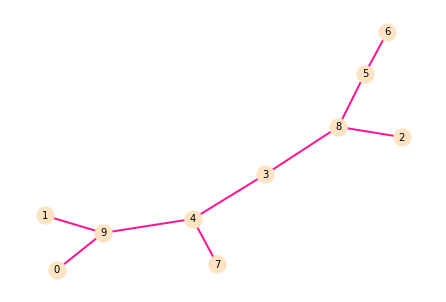

this is A_dict: 
{'2_8': [['t', 'a'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['c', '-'], ['c', '-']], '3_8': [['a', 'a'], ['a', 'a'], ['t', 't'], ['a', '-'], ['a', 'c'], ['g', 'g'], ['t', 'c']], '5_8': [['-', 'g'], ['a', 'g'], ['a', 'g'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['t', 'a']], '3_4': [['a', 'a'], ['a', 'g'], ['t', 'a'], ['c', 't'], ['g', '-'], ['c', 'c']], '5_6': [['g', 'c'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['g', 'c'], ['a', 'a'], ['-', 'c'], ['g', 'a'], ['a', 'a']], '4_7': [['a', 'g'], ['g', 'g'], ['-', 'c'], ['a', 'g'], ['t', 'c'], ['c', 't']], '4_9': [['a', 't'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['c', 't'], ['-', 'g']], '0_9': [['-', 'c'], ['t', 'c'], ['g', 'g'], ['-', 'a'], ['a', 'a'], ['c', 't'], ['t', 't'], ['g', 'g']], '1_9': [['t', 't'], ['g', 't'], ['a', 't'], ['c', 't'], ['t', 't'], ['g', 'g'], ['-', 't']]}
Total cost of MSA:1327


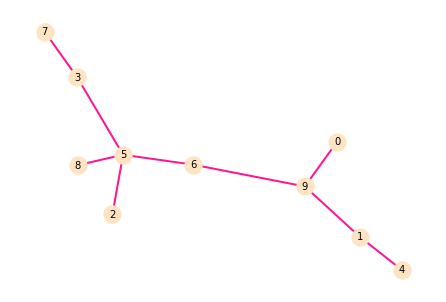

this is A_dict: 
{'2_5': [['t', 'a'], ['t', 'c'], ['a', 'g'], ['a', 't'], ['a', 'a'], ['c', 't']], '3_5': [['a', 'a'], ['c', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', '-']], '5_6': [['a', '-'], ['c', 't'], ['g', 'g'], ['t', 'c'], ['a', 'c'], ['t', 'c']], '5_8': [['-', 'c'], ['-', 'g'], ['a', 'g'], ['c', 'c'], ['g', 'a'], ['t', 't'], ['a', 'a'], ['-', 'g'], ['t', 't']], '3_7': [['a', 'g'], ['a', 'a'], ['-', 't'], ['-', 'c'], ['g', 'g'], ['-', 't'], ['t', 't'], ['a', 'a']], '6_9': [['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['-', 't']], '1_9': [['t', 't'], ['-', 'a'], ['g', 'a'], ['c', 't'], ['c', 't'], ['c', 'c'], ['t', 't']], '0_9': [['-', 'g'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['-', 't'], ['-', 'a'], ['c', 'c'], ['t', 't']], '1_4': [['t', 'c'], ['a', 'a'], ['-', 'g'], ['a', 'g'], ['t', 't'], ['t', 't'], ['c', 't'], ['t', 'g']]}
Total cost of MSA:1273


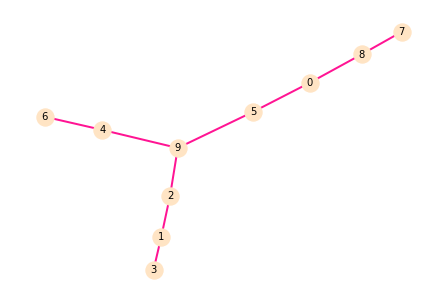

this is A_dict: 
{'2_9': [['a', 'a'], ['g', 'c'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['-', 't']], '1_2': [['a', 'a'], ['-', 't'], ['g', 'c'], ['a', 'g'], ['c', 'c'], ['g', 'a']], '5_9': [['a', 'a'], ['c', 'c'], ['a', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['-', 'c']], '4_9': [['a', 'a'], ['c', 'c'], ['a', 'a'], ['-', 't'], ['t', 't'], ['g', 'a'], ['t', 'a']], '1_3': [['a', 'a'], ['t', 'c'], ['c', 'c'], ['-', 'a'], ['-', 'a'], ['g', 'a'], ['c', 'c'], ['a', 'a']], '0_5': [['a', 'a'], ['c', 'c'], ['c', 't'], ['t', 't'], ['g', 'a'], ['-', 't'], ['t', 't'], ['-', 'c'], ['c', 'c']], '4_6': [['-', 'a'], ['a', 'a'], ['c', 't'], ['-', 'g'], ['a', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['a', 'a']], '0_8': [['-', 't'], ['a', 'a'], ['c', 't'], ['t', 't'], ['t', 't'], ['a', 'g'], ['t', '-'], ['t', 't'], ['c', 'c'], ['c', 'c']], '7_8': [['t', 't'], ['a', 't'], ['t', 'c'], ['t', 't'], ['t', 'a'], ['g', 'g'], ['t', 'c'], ['c', 't'], ['c', 'c']]}
Total cost of MSA:1232


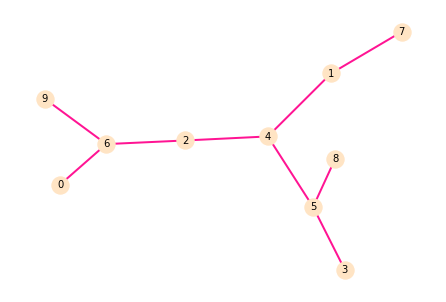

this is A_dict: 
{'0_6': [['a', 'c'], ['a', 'a'], ['a', 'g'], ['c', 'c'], ['a', 'g'], ['t', 'c'], ['a', 'a'], ['a', 't'], ['g', 'g']], '6_9': [['c', 'c'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', '-'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['g', '-']], '2_6': [['c', '-'], ['a', 'a'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['c', 't'], ['a', 'a'], ['t', 'c'], ['g', 't']], '2_4': [['a', '-'], ['a', 'g'], ['c', 'c'], ['g', 'g'], ['t', 'c'], ['a', '-'], ['c', 'c'], ['t', 'c']], '1_4': [['g', 'a'], ['c', 'c'], ['g', '-'], ['c', 'c'], ['c', 't'], ['c', 'g']], '4_5': [['g', 'g'], ['c', 'c'], ['g', 'g'], ['-', 'a'], ['-', 'a'], ['c', 'g'], ['c', 'c'], ['c', 'c']], '1_7': [['a', 't'], ['c', 't'], ['c', 't'], ['t', 't'], ['g', 'g']], '5_8': [['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 't'], ['a', 'g'], ['g', 'g'], ['-', 't'], ['c', 't'], ['c', 'c']], '3_5': [['g', 'g'], ['-', 'c'], ['c', 'c'], ['g', 'a'], ['a', 'g'], ['a', 'a'], ['g', 't'], ['c', 'c'], ['c', 't']]}
Total cost of MSA:1229


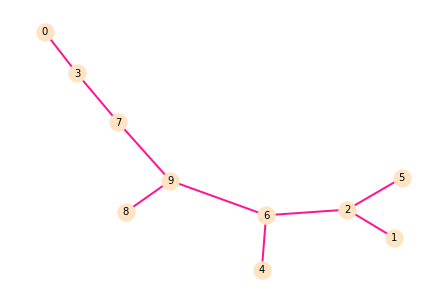

this is A_dict: 
{'4_6': [['a', 'c'], ['a', 'a'], ['g', '-'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['g', 't']], '6_9': [['c', 't'], ['a', 'a'], ['c', 't'], ['g', 'c'], ['g', 'g'], ['g', 'g'], ['t', 'c']], '2_6': [['-', 'c'], ['c', 'c'], ['a', 'a'], ['-', 'g'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['g', 'c'], ['t', 't']], '7_9': [['t', '-'], ['a', '-'], ['t', 't'], ['c', 'c'], ['g', 'a'], ['g', 'a'], ['c', 'c']], '8_9': [['-', 'c'], ['-', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', 't'], ['g', 't'], ['g', 'g'], ['c', 'c']], '2_5': [['c', 'c'], ['c', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', '-'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['-', 'a']], '1_2': [['-', 'a'], ['c', 't'], ['c', 'c'], ['a', 'g'], ['g', 'a'], ['c', '-'], ['a', 'a'], ['g', 'g'], ['c', 't'], ['t', 'c']], '3_7': [['t', 'g'], ['c', 'c'], ['a', 't'], ['a', 'a'], ['c', 't'], ['-', 'a']], '0_3': [['-', 'g'], ['g', 'g'], ['c', 'g'], ['t', 't'], ['a', 'a'], ['t', '-'], ['a', 'g']]}
Total cost of MSA:1443


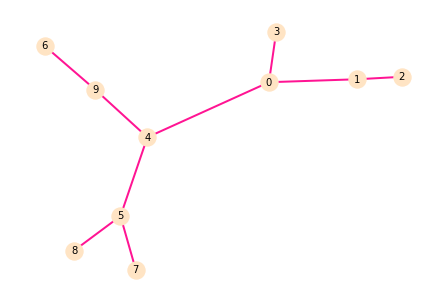

this is A_dict: 
{'1_2': [['g', 'g'], ['t', '-'], ['a', '-'], ['a', '-'], ['g', 'g'], ['g', 'g'], ['a', 'g'], ['t', 'c'], ['g', 'a']], '0_1': [['g', '-'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a']], '0_4': [['a', 'g'], ['g', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a']], '0_3': [['a', 't'], ['g', 'c'], ['g', 'c'], ['c', 'c'], ['a', 'a']], '4_5': [['-', 'c'], ['g', 'g'], ['a', 'a'], ['g', 't'], ['c', 't'], ['a', 'a']], '4_9': [['g', 'g'], ['-', 't'], ['a', 'a'], ['g', 'a'], ['c', 'c'], ['a', '-']], '5_8': [['c', 'a'], ['g', 'a'], ['a', 't'], ['t', 't'], ['t', 't'], ['a', 'g']], '5_7': [['c', 'c'], ['g', 'g'], ['-', 'c'], ['a', 'a'], ['-', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['-', 'g']], '6_9': [['g', 'c'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['c', 't']]}
Total cost of MSA:1011


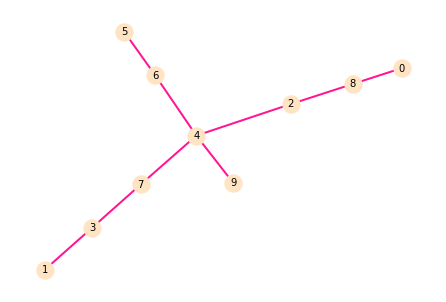

this is A_dict: 
{'0_8': [['c', '-'], ['a', 'a'], ['t', 't'], ['t', 'c'], ['t', 'g'], ['a', 'a'], ['c', 't'], ['a', 'a'], ['-', 'g'], ['c', 'c']], '2_8': [['a', '-'], ['t', 't'], ['c', 'c'], ['g', 'a'], ['a', 'a'], ['t', 't'], ['a', '-'], ['g', 'g'], ['c', '-']], '2_4': [['t', 'c'], ['c', 'c'], ['a', '-'], ['a', 'a'], ['t', 'c'], ['g', 'g']], '4_9': [['-', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', '-']], '4_6': [['-', 'g'], ['c', 't'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 't']], '4_7': [['-', 'a'], ['-', 'a'], ['c', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g']], '5_6': [['-', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', '-'], ['c', 'c'], ['t', '-']], '3_7': [['-', 'c'], ['a', 'g'], ['-', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['c', 't'], ['g', 'a']], '1_3': [['-', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', '-'], ['t', 't'], ['a', 'a']]}
Total cost of MSA:1229


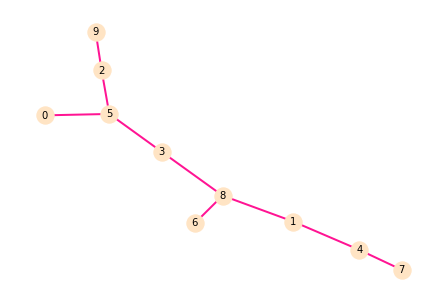

this is A_dict: 
{'0_5': [['a', 'g'], ['a', 'g'], ['a', 't'], ['c', 'c'], ['t', 'a'], ['c', 'c']], '3_5': [['g', 'g'], ['g', 'a'], ['-', 'c'], ['t', 'c'], ['c', 'c'], ['a', 'g'], ['c', 'c'], ['-', 'g']], '2_5': [['-', 't'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['c', 'g'], ['a', 'g'], ['-', 't'], ['c', 'c']], '3_8': [['g', '-'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'a'], ['c', 'g'], ['g', 'g']], '2_9': [['t', 'c'], ['g', 'a'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['g', 'a'], ['t', 'a'], ['c', 'c']], '1_8': [['a', '-'], ['c', '-'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 't'], ['g', 'g']], '6_8': [['a', 'a'], ['c', 't'], ['c', 't'], ['c', 't'], ['a', 'a'], ['-', 'c'], ['g', 't'], ['g', 'a']], '1_4': [['-', 'g'], ['c', 't'], ['c', 'a'], ['a', 'a'], ['t', 't'], ['g', 'g']], '4_7': [['-', 't'], ['g', 'a'], ['t', 't'], ['a', 'g'], ['-', 't'], ['a', 'a'], ['t', 't'], ['-', 'a'], ['g', 'g']]}
Total cost of MSA:1272


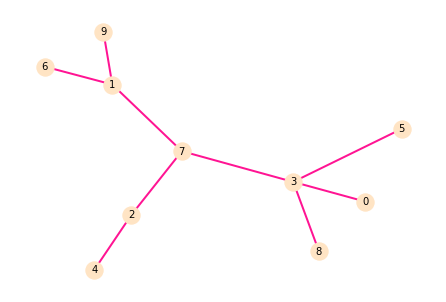

this is A_dict: 
{'2_4': [['g', 'g'], ['c', 'c'], ['t', 'c'], ['a', 'g'], ['t', '-'], ['t', 'a']], '2_7': [['g', 't'], ['c', 't'], ['-', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'g']], '3_7': [['t', 't'], ['t', 'a'], ['g', 'g'], ['c', 't'], ['g', 'c'], ['g', 'a']], '1_7': [['-', 'a'], ['t', 't'], ['-', 'g'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['g', 'a'], ['g', 'c']], '3_5': [['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'c']], '3_8': [['t', 'c'], ['a', 'a'], ['g', 'g'], ['t', 'g'], ['c', 'c'], ['a', '-']], '0_3': [['t', 'a'], ['a', 'a'], ['g', 'c'], ['t', 't'], ['c', 't'], ['a', 'g']], '1_6': [['a', 'a'], ['-', 'c'], ['t', 't'], ['g', 'c'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['a', 'c'], ['c', 'a']], '1_9': [['a', 'g'], ['t', 'g'], ['g', 'a'], ['t', 'a'], ['g', 'a'], ['c', 'g'], ['a', 'a'], ['c', 'c'], ['-', 'g']]}
Total cost of MSA:1181


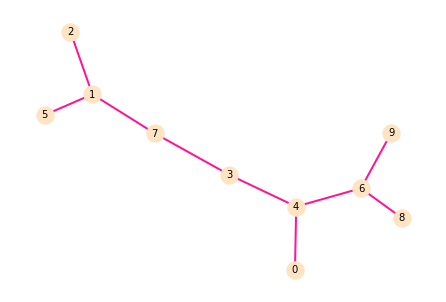

this is A_dict: 
{'0_4': [['a', 't'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['t', '-'], ['a', 'a'], ['t', '-'], ['c', 'a']], '3_4': [['t', 'c'], ['a', 'g'], ['t', 't'], ['g', '-'], ['c', 't'], ['a', 'g'], ['a', 'a']], '4_6': [['t', 't'], ['a', 'g'], ['t', 'c'], ['g', 'a'], ['c', 'g'], ['a', 'g'], ['a', 'g']], '3_7': [['c', 'c'], ['g', 'g'], ['t', 'c'], ['t', 'c'], ['g', 'g'], ['a', '-']], '6_9': [['-', 'g'], ['t', 't'], ['g', 't'], ['c', 'c'], ['a', 'c'], ['g', 'a'], ['g', 'g'], ['g', 'g']], '6_8': [['t', 'c'], ['g', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'a'], ['g', 'g'], ['-', 'c'], ['-', 't'], ['g', 'g']], '1_7': [['c', '-'], ['g', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['-', 'c']], '1_5': [['a', 'a'], ['c', 't'], ['-', 'g'], ['c', 't'], ['g', 'g'], ['c', '-']], '1_2': [['a', 'a'], ['c', 'a'], ['c', 'a'], ['g', 'a'], ['c', 'c'], ['-', 't']]}
Total cost of MSA:1146


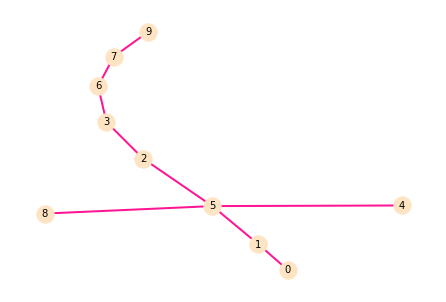

this is A_dict: 
{'0_1': [['g', 'a'], ['g', 'g'], ['a', 'c'], ['a', 'a'], ['c', 'g'], ['c', 't'], ['a', 'a'], ['c', 'g']], '1_5': [['a', '-'], ['g', 'g'], ['c', 't'], ['a', 'g'], ['g', 'a'], ['t', 't'], ['a', 'g'], ['g', 'g']], '2_5': [['g', 'a'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['t', '-'], ['g', 'g'], ['g', 'g']], '4_5': [['g', 'g'], ['t', 't'], ['g', '-'], ['a', '-'], ['t', 't'], ['g', 't'], ['g', 'g']], '5_8': [['g', 't'], ['t', 't'], ['g', 'g'], ['-', 'c'], ['a', 'a'], ['t', 't'], ['g', 'a'], ['g', 't']], '2_3': [['a', 'a'], ['t', 'c'], ['g', 'g'], ['-', 'a'], ['g', 'g'], ['g', 'a'], ['-', 'c'], ['g', 'g']], '3_6': [['a', 'a'], ['c', 'c'], ['g', 'a'], ['a', 'a'], ['g', 'c'], ['a', 'g'], ['c', 'c'], ['g', 't']], '6_7': [['a', '-'], ['c', 'c'], ['a', 'a'], ['a', 't'], ['c', 'c'], ['-', 'a'], ['g', 'g'], ['c', 'c'], ['t', 'c']], '7_9': [['c', 'a'], ['a', 'a'], ['t', 't'], ['-', 'c'], ['c', 'c'], ['a', 'g'], ['g', 'a'], ['c', 't'], ['c', 'c']]}
Total cost of MSA:1292


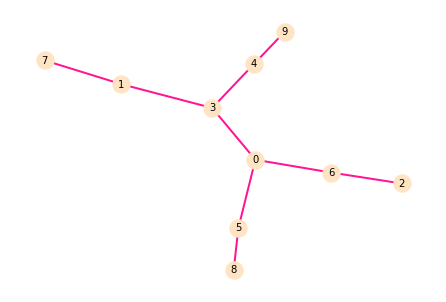

this is A_dict: 
{'2_6': [['t', 't'], ['c', 't'], ['t', 't'], ['c', 't'], ['t', 't'], ['t', 'g'], ['c', 't'], ['a', 'a'], ['c', '-']], '0_6': [['t', '-'], ['t', '-'], ['t', 't'], ['t', 'g'], ['t', 't'], ['g', 'g'], ['t', 't'], ['a', '-']], '0_5': [['t', 't'], ['g', 'a'], ['t', 'g'], ['g', 'g'], ['t', 't']], '0_3': [['t', 'a'], ['g', 'g'], ['-', 'a'], ['t', 'c'], ['g', 'a'], ['t', 'c']], '5_8': [['t', 't'], ['a', 'c'], ['g', 'a'], ['g', 'c'], ['t', 't']], '1_3': [['a', 'g'], ['g', 'g'], ['a', 'c'], ['c', 't'], ['a', 'a'], ['c', '-']], '3_4': [['-', 't'], ['a', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['-', 'g'], ['c', 't']], '1_7': [['g', 'a'], ['-', 't'], ['g', 'g'], ['c', 'c'], ['t', 'c'], ['a', 'g']], '4_9': [['t', 't'], ['g', 'g'], ['g', 'g'], ['a', 'g'], ['-', 't'], ['c', 't'], ['a', 'c'], ['g', 'g'], ['t', 'g']]}
Total cost of MSA:1294


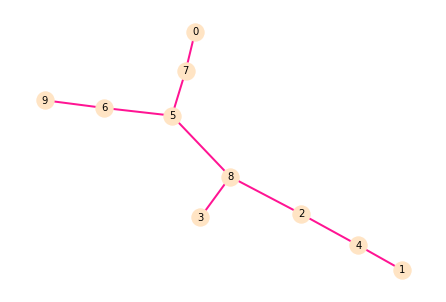

this is A_dict: 
{'0_7': [['a', 'g'], ['t', 'c'], ['t', 'c'], ['t', 't'], ['g', 'g'], ['t', 'c'], ['a', 'c'], ['t', 'c'], ['a', 'g']], '5_7': [['g', 'g'], ['c', 'c'], ['c', 't'], ['t', 't'], ['g', 'a'], ['c', '-'], ['c', '-'], ['c', 'c'], ['g', '-']], '5_8': [['g', '-'], ['c', 'c'], ['t', 'c'], ['t', 'c'], ['a', 'a'], ['c', 'c']], '5_6': [['g', 'g'], ['c', 'g'], ['t', 't'], ['t', 'c'], ['-', 'a'], ['a', 'a'], ['c', 't']], '2_8': [['c', 'c'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['a', 'a'], ['c', '-']], '3_8': [['c', 'a'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'g']], '6_9': [['g', '-'], ['g', 'g'], ['t', 't'], ['c', 'g'], ['a', 'g'], ['a', 'a'], ['t', 't']], '2_4': [['c', 't'], ['c', 'a'], ['a', 'a'], ['-', 't'], ['c', 'c'], ['a', 'a']], '1_4': [['t', 't'], ['a', 'a'], ['-', 'c'], ['a', 'g'], ['t', 't'], ['c', 't'], ['a', 'a'], ['-', 'g']]}
Total cost of MSA:1241


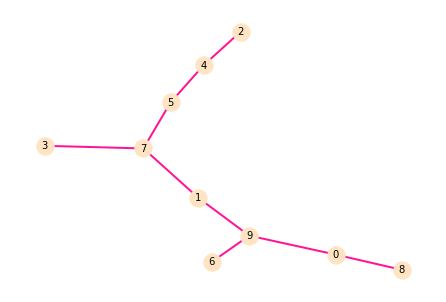

this is A_dict: 
{'0_9': [['g', 'g'], ['c', 't'], ['g', 'a'], ['c', 'c'], ['a', 'g'], ['a', 'c'], ['t', 't'], ['a', 'c'], ['a', 'g']], '0_8': [['g', 'a'], ['c', 't'], ['g', 'c'], ['c', 'c'], ['a', 'a'], ['a', 'g'], ['t', 'a'], ['a', 'a'], ['a', 't']], '1_9': [['g', '-'], ['t', 't'], ['a', 't'], ['c', 'c'], ['g', '-'], ['c', 't'], ['t', 't'], ['c', 'c'], ['g', 'g']], '6_9': [['g', 'a'], ['t', '-'], ['a', 'a'], ['c', '-'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['c', 't'], ['g', 'c']], '1_7': [['t', '-'], ['t', 't'], ['c', 'c'], ['t', 't'], ['t', 't'], ['c', 'c'], ['-', 'a'], ['g', 'g']], '3_7': [['t', 't'], ['c', 't'], ['t', 't'], ['t', 't'], ['c', 't'], ['a', 'g'], ['g', 't']], '5_7': [['t', 't'], ['c', 'c'], ['t', 'a'], ['t', 't'], ['c', 't'], ['a', 'a'], ['g', '-']], '4_5': [['t', 'a'], ['c', 't'], ['a', 'a'], ['t', '-'], ['t', 't'], ['a', 'g']], '2_4': [['-', 'g'], ['a', 'a'], ['t', 't'], ['a', 'g'], ['t', 'c'], ['g', 'a']]}
Total cost of MSA:1301


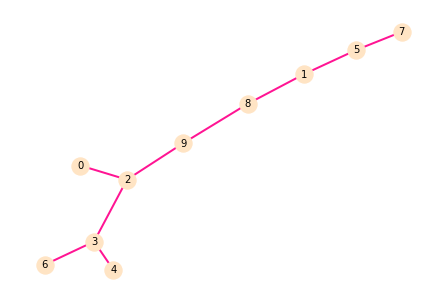

this is A_dict: 
{'2_3': [['a', 'g'], ['a', 'g'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['c', 't'], ['g', 'g']], '2_9': [['a', 'a'], ['a', 't'], ['g', 'g'], ['g', 'g'], ['g', 'a'], ['c', 't'], ['g', '-']], '0_2': [['a', '-'], ['a', 'a'], ['g', 'c'], ['g', 'a'], ['g', 'c'], ['c', 'c'], ['g', 'g']], '3_6': [['g', 'g'], ['g', 'g'], ['a', 't'], ['g', 'a'], ['g', 'a'], ['t', '-'], ['g', 'g']], '3_4': [['-', 'c'], ['-', 't'], ['g', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['t', '-'], ['g', 'a']], '8_9': [['a', 'a'], ['t', 't'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['a', 't'], ['t', 't']], '1_8': [['a', '-'], ['t', 'c'], ['g', 'g'], ['t', 't'], ['g', 't'], ['t', 'c'], ['t', 't']], '1_5': [['c', 'c'], ['g', 'g'], ['t', 'c'], ['t', 'c'], ['c', 'c'], ['-', 'a'], ['-', 'a'], ['t', 'c']], '5_7': [['-', 'g'], ['c', 'c'], ['g', 't'], ['c', 'c'], ['c', 'c'], ['c', 't'], ['a', 'g'], ['a', 'a'], ['c', 't']]}
Total cost of MSA:1376


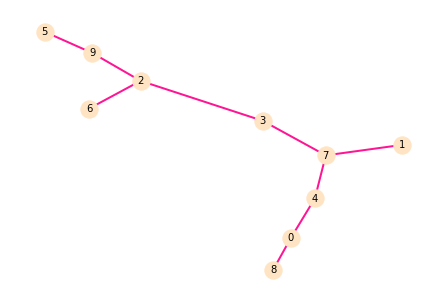

this is A_dict: 
{'1_7': [['t', 't'], ['c', 't'], ['t', 'a'], ['c', 'c'], ['t', 't'], ['a', '-']], '3_7': [['t', 't'], ['t', 'a'], ['a', 'g'], ['c', 't'], ['t', 'g']], '4_7': [['t', 'c'], ['t', 'c'], ['-', 'g'], ['a', 'g'], ['c', 'c'], ['t', 't'], ['-', 'c']], '2_3': [['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 'a'], ['g', 'g']], '0_4': [['-', 'g'], ['c', 'g'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['c', '-'], ['t', 't'], ['c', 'c']], '2_6': [['t', 'c'], ['a', 't'], ['g', 'g'], ['a', 'a'], ['g', 'a']], '2_9': [['t', 'a'], ['a', 'g'], ['g', 'g'], ['-', 't'], ['a', 'a'], ['-', 'c'], ['g', 'a']], '0_8': [['g', 'g'], ['g', 'g'], ['-', 'a'], ['c', 'a'], ['g', 'g'], ['-', 'a'], ['g', 'a'], ['t', 't'], ['c', 'c']], '5_9': [['-', 'g'], ['a', 'a'], ['g', 'a'], ['g', 'a'], ['t', 't'], ['a', 'g'], ['c', 'a'], ['a', 'g']]}
Total cost of MSA:1279


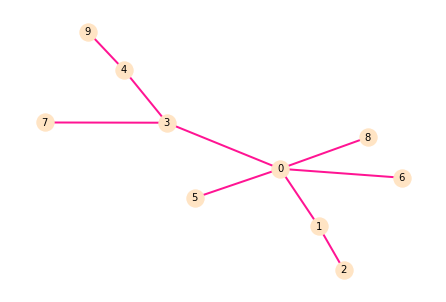

this is A_dict: 
{'3_4': [['t', 't'], ['g', 'g'], ['-', 't'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', '-'], ['t', '-'], ['g', 'g']], '4_9': [['t', 't'], ['g', 'a'], ['c', '-'], ['a', 'g'], ['g', 'g'], ['a', 'a'], ['-', 'c'], ['t', 'c'], ['g', 'a']], '3_7': [['t', 't'], ['g', 'a'], ['t', 'c'], ['c', 'c'], ['a', 't'], ['g', 'g'], ['g', 'g'], ['-', 'c']], '0_3': [['t', '-'], ['g', 'g'], ['t', 't'], ['c', 't'], ['a', 'a'], ['g', '-'], ['g', 'c']], '0_5': [['g', 'g'], ['t', 't'], ['-', 'a'], ['t', 'c'], ['a', 'g'], ['c', 'a']], '0_1': [['g', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['-', 'g'], ['c', 'c'], ['-', 't']], '0_6': [['-', 'g'], ['g', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['-', 'g'], ['-', 't']], '0_8': [['g', 'c'], ['t', 't'], ['t', 't'], ['a', 'c'], ['c', 'c'], ['-', 'a']], '1_2': [['t', '-'], ['t', '-'], ['t', 'c'], ['a', 'a'], ['g', 'a'], ['c', 't'], ['t', 't']]}
Total cost of MSA:1323


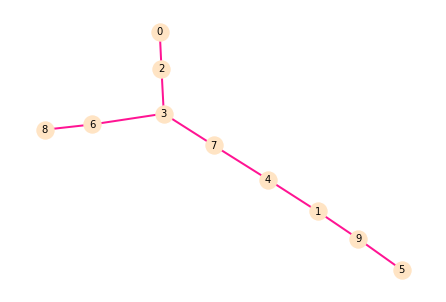

this is A_dict: 
{'0_2': [['t', '-'], ['g', 'a'], ['a', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['a', 'g'], ['t', '-']], '2_3': [['a', 'c'], ['g', 'a'], ['t', '-'], ['t', 'c'], ['a', 'a'], ['c', 't'], ['g', 'g']], '3_6': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'g'], ['-', 'c'], ['t', 't'], ['g', 'g']], '3_7': [['c', 't'], ['a', '-'], ['c', 't'], ['a', 'a'], ['t', 't'], ['g', 'c']], '6_8': [['c', 'c'], ['a', 't'], ['c', 't'], ['g', 'g'], ['c', 'c'], ['t', 'c'], ['g', 'a']], '4_7': [['-', 'g'], ['t', 't'], ['t', 'a'], ['a', 'a'], ['t', 't'], ['c', 'c']], '1_4': [['g', 'g'], ['t', 'c'], ['a', 'c'], ['a', 'g'], ['t', 't'], ['c', 't']], '1_9': [['g', 'g'], ['c', 'c'], ['-', 'g'], ['c', 'c'], ['g', 't'], ['t', 'c'], ['t', 'c']], '5_9': [['g', '-'], ['c', 't'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['c', 'c']]}
Total cost of MSA:995


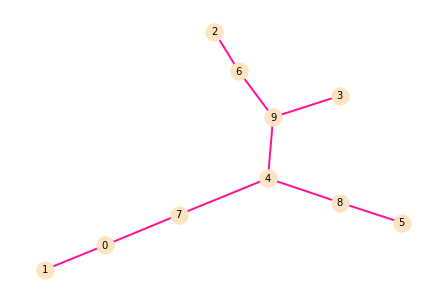

this is A_dict: 
{'2_6': [['c', 't'], ['a', 't'], ['a', 'a'], ['a', 'g'], ['a', 'a'], ['a', 'g'], ['c', 't'], ['g', 'g']], '6_9': [['t', '-'], ['t', 't'], ['a', '-'], ['g', '-'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', 'g']], '4_9': [['t', 'g'], ['a', 'a'], ['g', 'c'], ['t', 'c'], ['g', 'g']], '3_9': [['-', 'g'], ['t', 'c'], ['a', 'a'], ['g', 'a'], ['t', 't'], ['g', '-']], '4_7': [['-', 'c'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'g'], ['g', 'a']], '4_8': [['-', 'a'], ['-', 't'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['-', 'c'], ['-', 't']], '0_7': [['c', 'c'], ['g', '-'], ['a', 'c'], ['c', 'c'], ['g', 'a'], ['a', 'g']], '5_8': [['a', 'a'], ['t', 't'], ['g', '-'], ['a', 't'], ['c', 'c'], ['c', 't'], ['g', 'g'], ['c', 't'], ['-', 'a'], ['t', 't']], '0_1': [['c', 'c'], ['c', 'c'], ['-', 't'], ['c', 'c'], ['a', 'a'], ['-', 't'], ['-', 'g'], ['g', 'g']]}
Total cost of MSA:1357


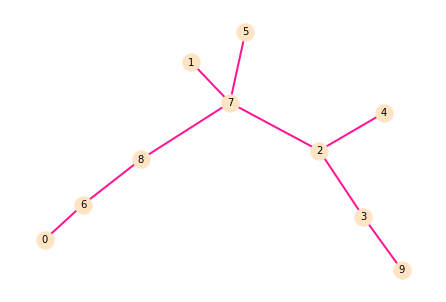

this is A_dict: 
{'0_6': [['t', 't'], ['c', '-'], ['c', 't'], ['c', 'c'], ['t', '-'], ['t', 'a'], ['t', 't'], ['g', 'a'], ['c', '-']], '6_8': [['t', 'a'], ['t', 'a'], ['c', 't'], ['a', 'g'], ['t', 'c'], ['a', 'a']], '7_8': [['a', 'a'], ['a', 'a'], ['t', 'c'], ['g', 'g'], ['c', '-'], ['a', 'g']], '2_7': [['-', 'c'], ['-', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'a'], ['g', 'g']], '5_7': [['a', 'a'], ['-', 't'], ['a', 'g'], ['-', 't'], ['c', 't'], ['g', 'g'], ['g', 'g']], '1_7': [['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['-', 't'], ['-', 'c'], ['-', 'c']], '2_4': [['c', 'c'], ['g', 'g'], ['a', '-'], ['a', 'a'], ['c', '-'], ['a', 'a'], ['g', 'g']], '2_3': [['-', 'a'], ['c', 't'], ['g', 'a'], ['a', 'a'], ['-', 'g'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'a']], '3_9': [['a', 'a'], ['t', 'a'], ['a', 'g'], ['a', 'c'], ['g', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'g'], ['a', 'a']]}
Total cost of MSA:1318


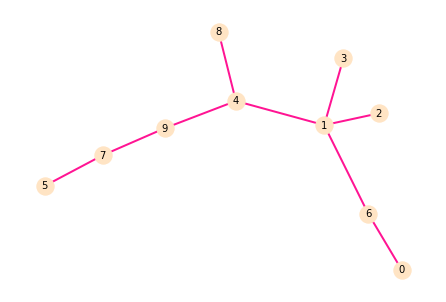

this is A_dict: 
{'0_6': [['a', 'g'], ['g', 'c'], ['a', 'a'], ['c', '-'], ['c', 'c'], ['t', 't'], ['c', 'g']], '1_6': [['g', 'g'], ['c', 'c'], ['a', 'g'], ['c', 'g'], ['t', 't'], ['-', 'g'], ['g', 'g']], '1_4': [['g', 'a'], ['c', 't'], ['g', 'g'], ['g', 'a'], ['t', 'c'], ['g', '-'], ['g', 'g']], '1_2': [['g', 'c'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['t', '-'], ['g', 'a'], ['g', 'a']], '1_3': [['g', 't'], ['c', 't'], ['g', 't'], ['g', 'c'], ['t', 't'], ['g', 'g'], ['g', 'g']], '4_9': [['-', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['c', 'a'], ['g', 'g'], ['-', 't']], '4_8': [['a', 'g'], ['t', 't'], ['g', 'c'], ['a', 'g'], ['c', 't'], ['g', '-']], '7_9': [['t', 't'], ['a', 'g'], ['t', '-'], ['g', 'a'], ['a', 'a'], ['a', 't'], ['g', 'g'], ['t', 'c']], '5_7': [['t', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['-', 'g'], ['t', 't'], ['g', 'a'], ['c', 't']]}
Total cost of MSA:1117


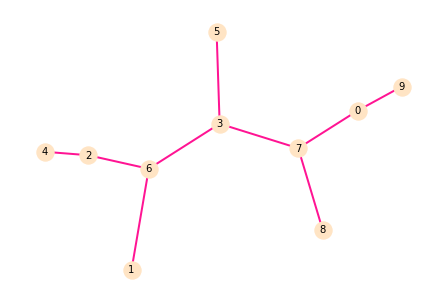

this is A_dict: 
{'3_7': [['c', 'c'], ['-', 'a'], ['c', 'c'], ['-', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'g']], '3_6': [['c', 'c'], ['c', 'c'], ['a', 'g'], ['-', 't'], ['g', 't'], ['a', 'g']], '3_5': [['c', 't'], ['c', 't'], ['a', 'g'], ['g', 'g'], ['a', 'a'], ['-', 'c'], ['-', 'c']], '0_7': [['c', 't'], ['a', 'a'], ['c', 'c'], ['g', 'a'], ['-', 'c'], ['a', 'a'], ['g', 'g'], ['-', 't'], ['g', 'g']], '7_8': [['c', '-'], ['a', 'a'], ['c', '-'], ['g', 'g'], ['a', 'a'], ['g', 'c'], ['g', 'g']], '1_6': [['c', '-'], ['c', 'c'], ['g', 'a'], ['t', 'c'], ['t', 't'], ['g', 'a']], '2_6': [['-', 'g'], ['-', 't'], ['c', 't'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 'c'], ['g', 'a']], '0_9': [['t', 'c'], ['a', 'g'], ['c', 'g'], ['a', 'g'], ['c', 't'], ['a', 'a'], ['g', 't'], ['t', 't'], ['g', 'g']], '2_4': [['g', 'g'], ['t', 'c'], ['-', 'g'], ['t', 'c'], ['c', 'c'], ['g', 'a'], ['t', 't'], ['c', 'a'], ['a', 't']]}
Total cost of MSA:1318


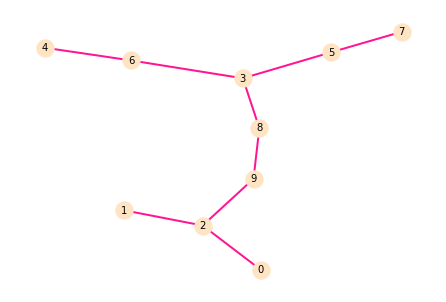

this is A_dict: 
{'4_6': [['t', 'c'], ['a', 'g'], ['c', 'g'], ['c', 'a'], ['c', 'c'], ['a', '-'], ['t', 't'], ['g', 'g'], ['t', 't']], '3_6': [['c', 'a'], ['g', 'a'], ['g', 'a'], ['a', 'g'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', '-']], '3_8': [['a', '-'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['c', '-'], ['t', 't'], ['g', 'a']], '3_5': [['a', 'a'], ['a', 't'], ['a', 't'], ['g', 'g'], ['c', 't'], ['t', 'c'], ['g', 'c']], '8_9': [['g', 'c'], ['a', 't'], ['g', 'a'], ['t', 't'], ['a', 'a']], '5_7': [['-', 'g'], ['a', 'a'], ['t', 'c'], ['-', 'g'], ['t', 'c'], ['g', 'g'], ['t', 'a'], ['c', 'c'], ['c', 't']], '2_9': [['c', '-'], ['t', 't'], ['a', 'a'], ['t', 't'], ['-', 'g'], ['a', 'a']], '0_2': [['t', 'c'], ['a', 'g'], ['t', 'c'], ['g', 'g'], ['a', 'g']], '1_2': [['-', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['-', 'a'], ['-', 'c'], ['-', 'a'], ['g', 'g'], ['a', 'a']]}
Total cost of MSA:1349


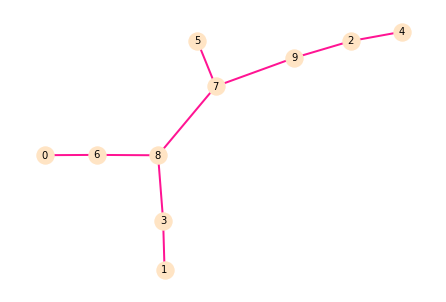

this is A_dict: 
{'2_4': [['t', 't'], ['a', 'g'], ['c', '-'], ['c', 'g'], ['a', 'a'], ['c', 't'], ['c', 'c'], ['t', 'c']], '2_9': [['t', '-'], ['a', 'a'], ['c', '-'], ['c', 't'], ['a', '-'], ['c', 'c'], ['c', 'c'], ['t', 't']], '7_9': [['a', 'a'], ['t', 'a'], ['c', 'c'], ['c', 'c'], ['t', 'a']], '7_8': [['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'g'], ['a', 't']], '5_7': [['a', 'g'], ['a', 'g'], ['c', 'a'], ['c', 'a'], ['a', 'g']], '3_8': [['a', 'c'], ['a', 'c'], ['c', 'a'], ['g', 'g'], ['t', 't']], '6_8': [['a', 'a'], ['a', 'a'], ['c', 't'], ['-', 'a'], ['g', 'g'], ['t', 't'], ['-', 'g'], ['-', 'a']], '1_3': [['c', 'c'], ['-', 'g'], ['c', 'c'], ['a', 't'], ['g', 'g'], ['t', 'c'], ['-', 'g']], '0_6': [['a', 'a'], ['a', 'a'], ['-', 'g'], ['t', 't'], ['a', 'g'], ['g', 'a'], ['t', 'c'], ['g', 'g'], ['a', 't']]}
Total cost of MSA:1152


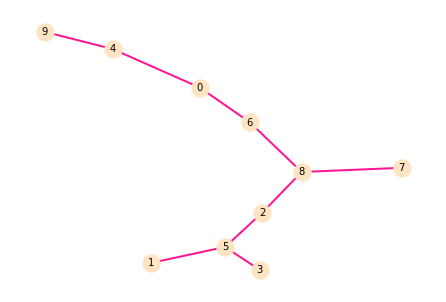

this is A_dict: 
{'1_5': [['g', '-'], ['c', 't'], ['c', 'c'], ['a', 'g'], ['c', 't'], ['g', '-'], ['a', 't'], ['a', 'a'], ['a', 'a']], '2_5': [['t', '-'], ['c', '-'], ['g', 'g'], ['t', 't'], ['t', 'c'], ['a', 'a'], ['a', 't']], '3_5': [['-', 'a'], ['t', 'a'], ['c', 'a'], ['g', 'a'], ['-', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['a', 'a']], '2_8': [['-', 't'], ['g', 'a'], ['t', 't'], ['c', 'c'], ['a', '-'], ['t', 't']], '6_8': [['t', 't'], ['a', 'a'], ['t', 'a'], ['c', 'c'], ['t', 'c']], '7_8': [['t', 'g'], ['a', 'g'], ['t', 't'], ['c', 'c'], ['t', 'c'], ['-', 'a']], '0_6': [['t', 'c'], ['a', 'c'], ['a', 'a'], ['c', 'a'], ['c', 'c']], '0_4': [['c', 'c'], ['c', 't'], ['a', 'g'], ['a', 'g'], ['c', 'c']], '4_9': [['c', 'c'], ['t', 't'], ['-', 'c'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['c', 'c'], ['-', 't']]}
Total cost of MSA:1315


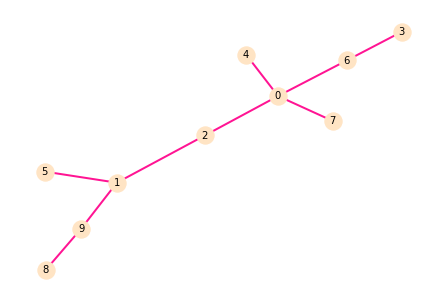

this is A_dict: 
{'1_2': [['t', 'a'], ['t', 't'], ['t', 't'], ['c', 'a'], ['t', 't']], '0_2': [['t', 'c'], ['t', 't'], ['t', 't'], ['-', 'g'], ['c', 'c'], ['t', 't'], ['-', 'g'], ['-', 'a']], '1_5': [['a', 'g'], ['t', 't'], ['-', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['-', 'a']], '1_9': [['a', 'a'], ['-', 'g'], ['t', 'g'], ['t', 'a'], ['a', 'a'], ['t', 'c']], '0_4': [['c', 't'], ['t', 'c'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['t', '-'], ['g', 'a'], ['a', 'a']], '0_7': [['c', 'a'], ['t', 't'], ['t', 't'], ['-', 'g'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['g', '-'], ['a', 'a']], '0_6': [['c', 't'], ['t', 't'], ['t', 't'], ['-', 'c'], ['g', 'a'], ['c', 'c'], ['t', 'g'], ['g', 'g'], ['a', 'g']], '8_9': [['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['-', 'g'], ['c', 't'], ['-', 'a']], '3_6': [['t', 'c'], ['t', 'g'], ['t', 't'], ['c', 't'], ['a', 'a'], ['c', 'a'], ['g', 'g'], ['g', 'a'], ['g', 'g']]}
Total cost of MSA:1291


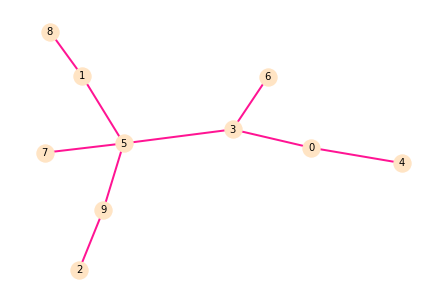

this is A_dict: 
{'2_9': [['g', '-'], ['c', 'c'], ['g', 'g'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['-', 't'], ['a', 'a']], '5_9': [['c', '-'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['g', 't'], ['g', 'c'], ['a', 'a'], ['t', 't'], ['a', '-']], '5_7': [['g', 'g'], ['a', 'a'], ['c', 'c'], ['t', 'g'], ['c', 'c'], ['a', '-'], ['t', 't']], '3_5': [['g', '-'], ['a', 'a'], ['c', 'c'], ['t', '-'], ['c', 'c'], ['a', 'g'], ['t', 't']], '1_5': [['g', 'g'], ['a', 't'], ['c', 'c'], ['t', 't'], ['c', '-'], ['a', 'a'], ['t', 't'], ['-', 'g']], '3_6': [['a', 'c'], ['c', 'c'], ['c', 't'], ['g', 't'], ['t', 'c']], '0_3': [['a', 'g'], ['c', 'c'], ['-', 'a'], ['c', 'a'], ['g', 'a'], ['t', 'c']], '1_8': [['-', 't'], ['-', 'g'], ['-', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'g'], ['t', '-'], ['g', 'g']], '0_4': [['g', 'a'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['-', 't'], ['a', 'a'], ['c', 'c']]}
Total cost of MSA:1225


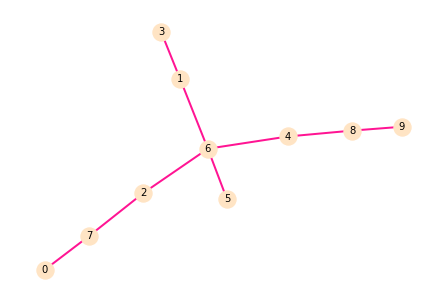

this is A_dict: 
{'0_7': [['t', '-'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['t', 'a'], ['g', 'a'], ['g', 'g']], '2_7': [['t', 't'], ['g', 'a'], ['c', '-'], ['a', 'a'], ['a', 't'], ['g', 'g']], '2_6': [['t', 'a'], ['a', 'a'], ['a', 'a'], ['t', 'a'], ['g', 'a']], '4_6': [['a', 'g'], ['a', 'g'], ['a', 'g'], ['a', 'a'], ['a', 't']], '1_6': [['-', 'g'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['-', 'c']], '5_6': [['a', 'a'], ['a', 't'], ['a', 't'], ['a', 'g'], ['a', 'a']], '4_8': [['g', 'a'], ['g', 'g'], ['g', 'g'], ['-', 't'], ['a', 'c'], ['t', 'c']], '1_3': [['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'c'], ['a', 'c'], ['a', 'a'], ['c', 't'], ['-', 'g']], '8_9': [['a', 't'], ['g', 'g'], ['-', 'c'], ['g', 'g'], ['t', 't'], ['-', 'a'], ['c', 'c'], ['c', 'c']]}
Total cost of MSA:1103


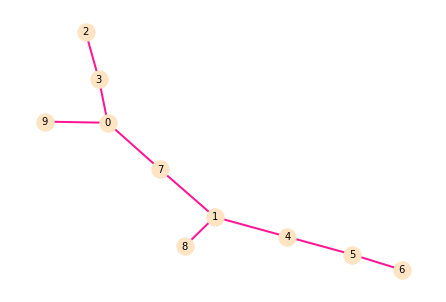

this is A_dict: 
{'0_7': [['t', 'c'], ['a', 'a'], ['g', 'g'], ['-', 't'], ['a', 'g'], ['t', 't'], ['t', 'c']], '0_9': [['t', 't'], ['a', 'c'], ['g', 'a'], ['a', 'a'], ['t', '-'], ['t', 't']], '0_3': [['t', 't'], ['a', 'g'], ['g', 'c'], ['a', 'c'], ['t', 't'], ['t', 'c']], '1_7': [['c', 'c'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', '-'], ['t', 't'], ['c', 'a']], '2_3': [['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['c', 't'], ['-', 'a']], '1_4': [['c', 'a'], ['a', 'a'], ['g', 't'], ['t', 't'], ['t', 'c'], ['a', 'g']], '1_8': [['-', 'a'], ['c', 'g'], ['a', 'a'], ['g', 'g'], ['t', 'g'], ['t', 't'], ['a', 'a']], '4_5': [['a', 'a'], ['a', 'c'], ['t', 't'], ['t', 'c'], ['c', 'a'], ['g', 'a']], '5_6': [['a', 'a'], ['-', 'c'], ['c', 'c'], ['-', 'g'], ['t', 't'], ['-', 'a'], ['c', 'c'], ['a', 'g'], ['a', 'a']]}
Total cost of MSA:1227


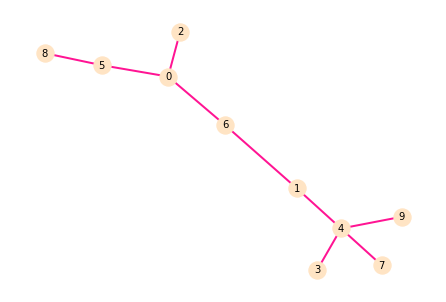

this is A_dict: 
{'5_8': [['a', 'g'], ['c', 'g'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['-', 'c'], ['a', 'a'], ['a', 'a']], '0_5': [['a', 'g'], ['c', 't'], ['c', 't'], ['c', 'c'], ['a', '-'], ['a', 'c'], ['a', 'a']], '0_6': [['g', 'a'], ['t', 't'], ['t', 't'], ['c', 'a'], ['c', 'c'], ['a', '-']], '0_2': [['g', 'g'], ['t', 'g'], ['t', 't'], ['c', 't'], ['c', 't'], ['a', 't']], '1_6': [['a', 'c'], ['t', 't'], ['t', 'c'], ['a', 'a'], ['c', 'c']], '1_4': [['c', 'c'], ['-', 'g'], ['t', 't'], ['-', 'a'], ['-', 'a'], ['-', 'g'], ['c', 'c'], ['a', 'g'], ['c', 'c']], '4_9': [['c', 't'], ['g', '-'], ['t', 't'], ['a', 'a'], ['a', 'g'], ['g', 'g'], ['c', 'c'], ['g', 'c'], ['c', 'c']], '4_7': [['c', 'c'], ['g', 'g'], ['t', '-'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['-', 't'], ['c', 'c'], ['g', 'g'], ['c', '-']], '3_4': [['-', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['a', 'g'], ['g', 'a'], ['c', '-'], ['g', 'g'], ['c', 't']]}
Total cost of MSA:1464


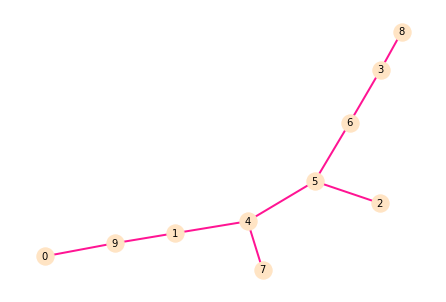

this is A_dict: 
{'1_4': [['g', 'a'], ['t', 't'], ['c', 'c'], ['c', 'a'], ['c', 'c'], ['c', 'c'], ['g', '-'], ['g', '-']], '1_9': [['g', 't'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['c', 't'], ['c', 't'], ['g', 't'], ['g', 'a']], '4_7': [['a', 'a'], ['t', 'c'], ['c', 't'], ['a', 'g'], ['c', '-'], ['c', 'c']], '4_5': [['a', 'a'], ['t', '-'], ['c', 'g'], ['a', 'a'], ['c', 't'], ['c', 't']], '0_9': [['t', 'c'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['t', 't'], ['t', 't'], ['-', 'a'], ['t', 't'], ['a', 'a']], '2_5': [['a', 'a'], ['g', 'a'], ['a', 'g'], ['t', 't'], ['t', 'a']], '5_6': [['-', 'g'], ['a', 'a'], ['g', 'a'], ['a', 'a'], ['t', 'a'], ['t', 't']], '3_6': [['g', 'g'], ['a', 'a'], ['a', 't'], ['a', 'a'], ['a', 'g'], ['t', 'a']], '3_8': [['-', 'a'], ['-', 'g'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['a', 'a'], ['g', 'g'], ['-', 'a'], ['a', 'a']]}
Total cost of MSA:1296


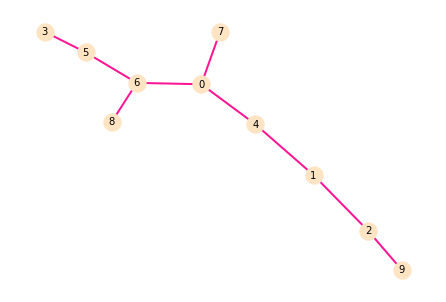

this is A_dict: 
{'1_2': [['g', 'a'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['c', 'a']], '2_9': [['-', 't'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['t', 'c'], ['c', 'c'], ['-', 'g']], '1_4': [['a', 'a'], ['-', 'c'], ['a', 'g'], ['c', 't'], ['t', 't'], ['a', 'a']], '0_4': [['a', 'a'], ['c', 'g'], ['g', 'g'], ['t', 'g'], ['t', 'c'], ['a', 'g']], '0_7': [['-', 'c'], ['a', 'g'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'a'], ['g', 'a']], '0_6': [['a', 'g'], ['-', 'c'], ['g', 'a'], ['-', 'c'], ['g', 'g'], ['g', 'g'], ['c', 't'], ['g', 'g']], '5_6': [['g', '-'], ['c', 't'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['g', 'a'], ['t', '-'], ['g', 'g']], '6_8': [['g', 't'], ['c', 't'], ['a', 'c'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['t', 't'], ['-', 'g'], ['g', 'g']], '3_5': [['-', 'a'], ['t', 't'], ['a', 'a'], ['t', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'a'], ['-', 't']]}
Total cost of MSA:1255


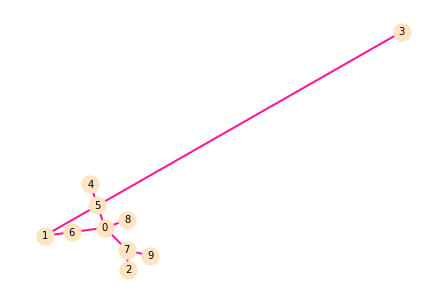

this is A_dict: 
{'0_8': [['t', 'g'], ['t', 't'], ['a', '-'], ['c', 't'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['a', 'a'], ['c', '-']], '0_7': [['g', 'g'], ['t', '-'], ['t', 'g'], ['a', 'a'], ['t', 't'], ['g', 'a'], ['a', 'g']], '0_5': [['g', '-'], ['t', '-'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['-', 't']], '0_6': [['g', 'a'], ['t', '-'], ['t', 't'], ['a', 'g'], ['t', 'c'], ['g', 'g'], ['-', 'c'], ['a', 'g']], '2_7': [['-', 'c'], ['g', 'g'], ['-', 'c'], ['g', 'g'], ['a', 'g'], ['t', 't'], ['a', 'g'], ['g', 'g']], '7_9': [['g', 'g'], ['-', 'a'], ['g', 'g'], ['-', 'a'], ['a', 'a'], ['-', 't'], ['t', 't'], ['a', 't'], ['g', 'a']], '4_5': [['t', 't'], ['a', 't'], ['t', 't'], ['g', 'g'], ['a', 't'], ['t', 't']], '1_6': [['-', 'c'], ['a', 'a'], ['t', 'c'], ['g', '-'], ['c', 'c'], ['g', 'c'], ['c', 'c'], ['g', 'g']], '1_3': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g']]}
Total cost of MSA:1250


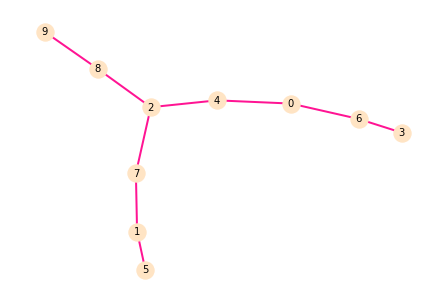

this is A_dict: 
{'0_6': [['t', 't'], ['t', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'g'], ['-', 't'], ['a', 'a']], '0_4': [['t', 'a'], ['t', 'g'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['a', 'a']], '3_6': [['t', 'c'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['c', 'a'], ['g', 'a'], ['t', 't'], ['a', 'g']], '2_4': [['a', 'a'], ['g', 'a'], ['c', '-'], ['c', 't'], ['a', 'a'], ['a', 'c']], '2_7': [['a', 'g'], ['a', 'a'], ['t', 'c'], ['-', 'a'], ['a', 'a'], ['c', 'c']], '2_8': [['a', 'c'], ['a', 't'], ['t', 't'], ['a', 'g'], ['c', 'c']], '1_7': [['g', 'g'], ['a', 'a'], ['c', '-'], ['a', 'a'], ['a', 'c'], ['c', 'c']], '8_9': [['c', 'c'], ['t', 't'], ['-', 'a'], ['t', 't'], ['g', 'g'], ['c', 't']], '1_5': [['g', 'a'], ['a', 'a'], ['a', 'a'], ['-', 'g'], ['-', 'c'], ['c', 'c'], ['-', 't'], ['c', 'c']]}
Total cost of MSA:1179


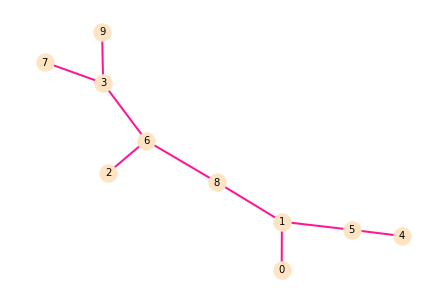

this is A_dict: 
{'2_6': [['t', '-'], ['a', '-'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['t', 't'], ['c', '-'], ['g', 'g']], '6_8': [['a', 'a'], ['g', 'a'], ['t', 'g'], ['c', 'c'], ['t', 't'], ['g', '-']], '3_6': [['a', 'a'], ['g', '-'], ['t', 't'], ['c', 'g'], ['t', 'g'], ['g', 'g']], '1_8': [['-', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'a'], ['c', 'g'], ['t', 'c']], '3_7': [['a', 'g'], ['t', 't'], ['g', 't'], ['g', 'g'], ['g', 't']], '3_9': [['a', 'a'], ['-', 'g'], ['-', 'g'], ['t', 't'], ['g', 'g'], ['-', 'c'], ['g', 'g'], ['g', 'a']], '1_5': [['c', 't'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'a'], ['c', 't'], ['-', 'a']], '0_1': [['-', 'a'], ['c', 'c'], ['a', 'g'], ['a', 'a'], ['a', 'a'], ['-', 'c'], ['-', 'c'], ['g', 'g'], ['c', 'c']], '4_5': [['-', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['-', 't'], ['a', 't'], ['a', 'a'], ['t', 'c'], ['a', 'a']]}
Total cost of MSA:1303


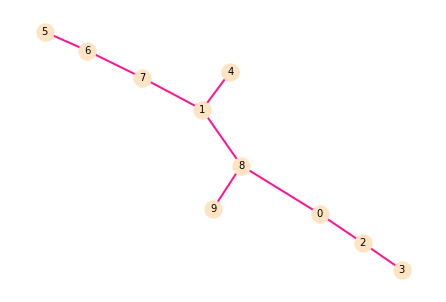

this is A_dict: 
{'1_4': [['a', 'c'], ['a', 'a'], ['a', 'g'], ['g', 'g'], ['-', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['-', 't']], '1_7': [['a', 't'], ['a', 'g'], ['a', 'a'], ['g', 'c'], ['c', 'c'], ['c', 'g'], ['a', 'a']], '1_8': [['a', 'g'], ['a', 'c'], ['a', 'a'], ['g', '-'], ['c', '-'], ['c', 'c'], ['a', 'a']], '6_7': [['t', 'a'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'g'], ['-', 'c']], '0_8': [['g', 'g'], ['c', 't'], ['a', 'g'], ['c', 't'], ['a', 'g']], '8_9': [['g', 'a'], ['c', 'c'], ['a', 'a'], ['c', 'g'], ['a', 't']], '5_6': [['-', 't'], ['a', 't'], ['g', 'a'], ['a', 'a'], ['c', 't'], ['a', 'a'], ['c', '-'], ['g', 'g'], ['g', 'g'], ['c', 't']], '0_2': [['g', 'a'], ['-', 't'], ['t', 't'], ['-', 'c'], ['g', 'g'], ['-', 'c'], ['-', 'c'], ['t', 't'], ['g', 'g']], '2_3': [['a', 't'], ['t', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'a'], ['c', 't'], ['t', 't'], ['g', 'c']]}
Total cost of MSA:1361


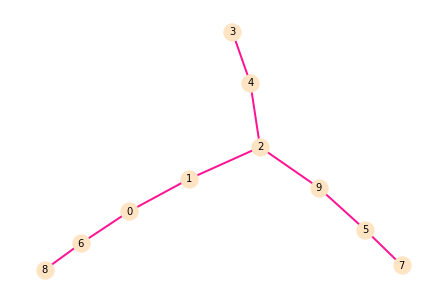

this is A_dict: 
{'3_4': [['g', 'a'], ['-', 'c'], ['g', 'g'], ['g', 'a'], ['g', 'c'], ['c', 'c'], ['t', 'c']], '2_4': [['g', 'a'], ['g', 't'], ['g', 'g'], ['g', 'g'], ['c', '-'], ['t', 'a']], '1_2': [['a', 'g'], ['t', 'c'], ['g', 'a'], ['g', 't'], ['a', 'g']], '2_9': [['a', 'c'], ['t', 't'], ['-', 'a'], ['g', 'g'], ['g', 'a'], ['-', 'c'], ['a', 'a']], '0_1': [['g', 'g'], ['c', 'c'], ['-', 'a'], ['a', 'a'], ['-', 'g'], ['t', 't'], ['g', 'g'], ['-', 'a']], '5_9': [['c', 'c'], ['t', 't'], ['-', 'c'], ['a', 't'], ['g', 'g'], ['a', 'g'], ['c', 't'], ['a', '-']], '0_6': [['-', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'g'], ['a', 'g'], ['g', 'g'], ['t', 'a'], ['g', 'a'], ['a', 'g']], '5_7': [['c', 'c'], ['t', 'c'], ['c', 'c'], ['t', 't'], ['-', 'a'], ['-', 'a'], ['g', 'g'], ['g', 'a'], ['t', 'a']], '6_8': [['g', 'g'], ['g', 'a'], ['c', '-'], ['g', 'g'], ['g', 'c'], ['g', 't'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['-', 'c']]}
Total cost of MSA:1523


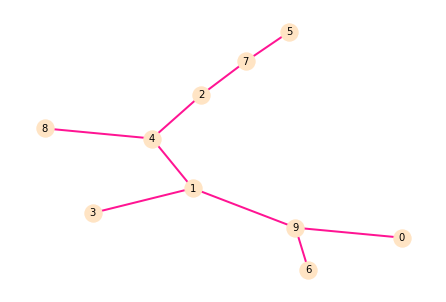

this is A_dict: 
{'0_9': [['-', 'a'], ['t', 'c'], ['g', 'a'], ['g', 'g'], ['a', 'a'], ['t', '-']], '6_9': [['a', 'a'], ['c', 'c'], ['a', 'a'], ['-', 'c'], ['-', 't'], ['g', 'g'], ['a', 'a']], '1_9': [['a', 'g'], ['c', 't'], ['a', 'g'], ['g', 't'], ['a', 'g']], '1_3': [['-', 'a'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['t', 't'], ['g', 't']], '1_4': [['g', 'g'], ['t', 'c'], ['-', 'a'], ['g', 'a'], ['t', 't'], ['g', 'c']], '2_4': [['g', '-'], ['c', 't'], ['a', 'a'], ['a', 'a'], ['-', 'c'], ['t', 'c'], ['c', 'c']], '4_8': [['g', 'a'], ['c', 'a'], ['a', 'a'], ['a', 'a'], ['t', 'c'], ['c', 'g']], '2_7': [['t', 'g'], ['a', 'a'], ['a', 'a'], ['-', 't'], ['-', 'c'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['c', 'c']], '5_7': [['g', 'a'], ['a', 't'], ['a', 'a'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'g'], ['c', 'c']]}
Total cost of MSA:1231


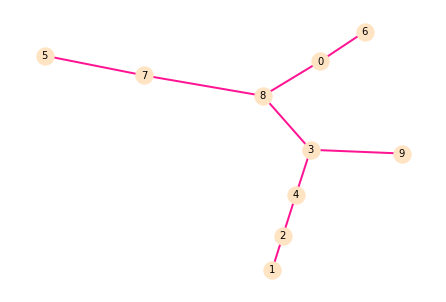

this is A_dict: 
{'1_2': [['t', '-'], ['t', 'c'], ['a', 'a'], ['t', '-'], ['t', 't'], ['t', 't'], ['a', 'g']], '2_4': [['c', 't'], ['a', 't'], ['t', 'c'], ['t', 'g'], ['g', 'g']], '3_4': [['t', 'a'], ['t', 'g'], ['c', 'c'], ['g', 'g'], ['g', 't']], '3_8': [['a', 'a'], ['g', 'a'], ['c', 'g'], ['g', 'a'], ['t', 'c']], '3_9': [['a', 'g'], ['-', 'c'], ['-', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'c'], ['t', 't']], '7_8': [['a', 'a'], ['-', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'g'], ['c', 'g']], '0_8': [['-', 't'], ['a', 'g'], ['a', 'g'], ['g', 'g'], ['a', 'a'], ['-', 't'], ['c', 't']], '5_7': [['a', 'g'], ['g', 'g'], ['-', 'a'], ['a', 'a'], ['g', 'a'], ['g', 'g'], ['g', 'a']], '0_6': [['t', 'g'], ['g', 'g'], ['g', 'g'], ['g', 't'], ['a', 'a'], ['t', 'c'], ['t', 't'], ['-', 'a']]}
Total cost of MSA:1127


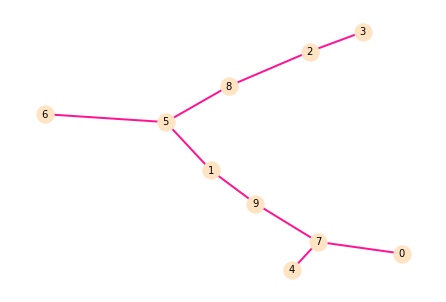

this is A_dict: 
{'2_3': [['a', '-'], ['c', 'c'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['a', '-'], ['a', 'a'], ['a', 'a'], ['g', '-']], '2_8': [['c', 'c'], ['t', 't'], ['g', 'a'], ['c', '-'], ['a', 'g'], ['a', 'a']], '5_8': [['c', 'g'], ['t', 'c'], ['a', 'a'], ['g', 't'], ['a', 'a']], '1_5': [['g', 'a'], ['c', 't'], ['a', 'g'], ['t', 't'], ['a', 'g']], '5_6': [['-', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', '-']], '1_9': [['-', 't'], ['-', 'g'], ['-', 't'], ['a', 'a'], ['t', 't'], ['g', 'a'], ['t', 't'], ['g', 'g']], '7_9': [['t', 't'], ['g', 'g'], ['t', 'g'], ['a', 'a'], ['t', 'c'], ['a', '-'], ['t', 't'], ['g', 'g']], '4_7': [['t', 't'], ['g', 'g'], ['g', 'g'], ['a', 'g'], ['c', 't'], ['-', 'g'], ['t', 'c'], ['g', 't']], '0_7': [['t', 'a'], ['g', 'a'], ['g', 'a'], ['a', 'a'], ['-', 'g'], ['c', 't'], ['t', 't'], ['-', 'c'], ['g', 'g']]}
Total cost of MSA:1242


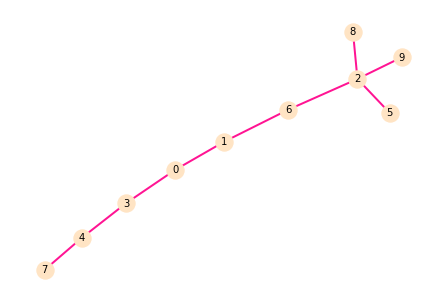

this is A_dict: 
{'0_3': [['a', 'c'], ['c', 'c'], ['c', 't'], ['a', 'a'], ['g', 'a'], ['t', 't'], ['t', 't'], ['-', 'a'], ['c', 't']], '0_1': [['a', 'a'], ['c', 'c'], ['c', 't'], ['a', 'c'], ['g', 'g'], ['t', '-'], ['t', 'c'], ['c', 'g']], '3_4': [['c', 't'], ['c', 'g'], ['t', 'c'], ['a', '-'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 'c']], '1_6': [['a', 'a'], ['c', '-'], ['t', 't'], ['c', 't'], ['g', 'g'], ['c', 'a'], ['g', 'g']], '4_7': [['t', 't'], ['g', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'c'], ['c', 'g']], '2_6': [['a', 'a'], ['t', 't'], ['t', 'a'], ['g', 'c'], ['a', 'a'], ['g', 'a']], '2_5': [['a', 'a'], ['t', 't'], ['a', 'g'], ['-', 't'], ['-', 't'], ['c', 'c'], ['a', 'g'], ['a', 'a'], ['-', 't']], '2_8': [['a', 'g'], ['t', 'g'], ['a', 'a'], ['c', 't'], ['a', 'a'], ['a', 'a'], ['-', 't'], ['-', 'c']], '2_9': [['a', '-'], ['t', 't'], ['a', 'a'], ['c', 'a'], ['a', 'g'], ['a', 'g'], ['-', 't']]}
Total cost of MSA:1419


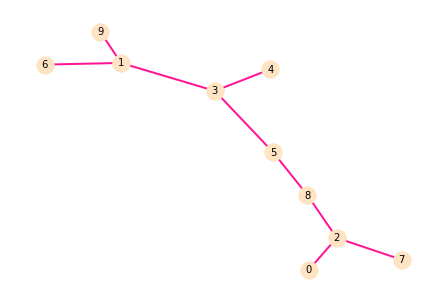

this is A_dict: 
{'1_3': [['t', 'c'], ['t', 'c'], ['a', 'g'], ['t', 't'], ['-', 'g'], ['c', 't']], '1_6': [['-', 'a'], ['-', 'c'], ['t', 'c'], ['t', 't'], ['a', 'a'], ['-', 'g'], ['t', 't'], ['c', 'c']], '1_9': [['-', 'a'], ['t', 't'], ['-', 'g'], ['t', 't'], ['a', 't'], ['t', 't'], ['c', 'c'], ['-', 'a']], '3_5': [['c', 'c'], ['-', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'a'], ['t', 't']], '3_4': [['c', 't'], ['c', 'c'], ['g', 'c'], ['t', 't'], ['g', 'g'], ['-', 'a'], ['t', 'g']], '5_8': [['c', 'a'], ['g', 'a'], ['c', 'c'], ['g', '-'], ['t', 'c'], ['a', 'a'], ['t', 'c']], '2_8': [['a', 'g'], ['a', 'a'], ['c', 't'], ['-', 'a'], ['c', 'c'], ['-', 'g'], ['a', 'g'], ['c', 'c']], '2_7': [['-', 'g'], ['g', 'g'], ['a', 'a'], ['t', 'a'], ['a', 'g'], ['c', 'c'], ['g', 'g'], ['g', 'a'], ['c', 'c']], '0_2': [['g', '-'], ['a', 'a'], ['t', 'c'], ['a', 'a'], ['c', 'g'], ['g', 'g'], ['g', 'a'], ['c', 't']]}
Total cost of MSA:1204


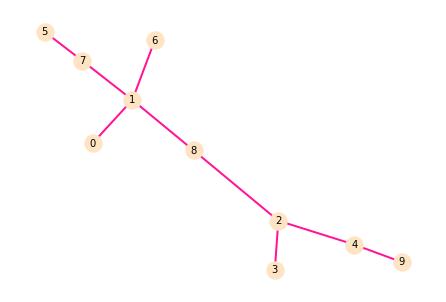

this is A_dict: 
{'0_1': [['c', '-'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', '-'], ['a', 'a']], '1_6': [['g', 'g'], ['a', 'a'], ['g', 't'], ['a', 'g'], ['a', 'g']], '1_8': [['g', 'a'], ['a', 't'], ['g', 'a'], ['a', 'a'], ['a', 'g']], '1_7': [['g', 'g'], ['-', 'c'], ['-', 't'], ['a', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a']], '2_8': [['a', 'a'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['g', 't']], '5_7': [['g', 'a'], ['c', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['-', 't'], ['a', 'a'], ['a', 'c']], '2_4': [['a', 't'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['t', 't']], '2_3': [['a', 'g'], ['t', 't'], ['a', 'g'], ['a', 't'], ['t', 't'], ['-', 'a']], '4_9': [['t', 't'], ['t', 'g'], ['g', 'g'], ['a', 't'], ['t', 'c']]}
Total cost of MSA:913


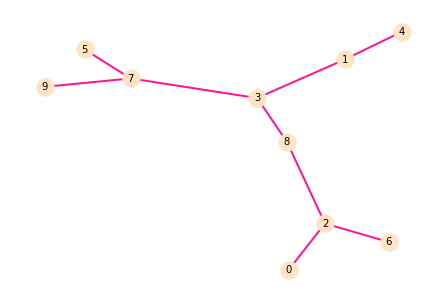

this is A_dict: 
{'5_7': [['g', '-'], ['g', 'g'], ['g', 'a'], ['t', '-'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', '-'], ['t', '-']], '3_7': [['g', 'c'], ['a', 'a'], ['-', 't'], ['-', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g']], '7_9': [['g', 'g'], ['-', 'a'], ['a', 'a'], ['g', 'a'], ['-', 't'], ['g', 'a'], ['-', 't'], ['g', 'a']], '1_3': [['c', 'c'], ['a', 'g'], ['t', 'c'], ['c', 'c'], ['-', 't'], ['g', 'g'], ['-', 't'], ['g', 'g'], ['g', 'g']], '3_8': [['c', 't'], ['a', '-'], ['t', 'c'], ['c', 'c'], ['g', '-'], ['g', 'c'], ['g', 'a']], '1_4': [['c', 't'], ['g', 'c'], ['c', 'c'], ['c', 'g'], ['t', 't'], ['g', 'g'], ['t', 't'], ['g', 't'], ['g', 'a']], '2_8': [['t', 't'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['a', 't']], '0_2': [['t', 'a'], ['c', 'c'], ['c', 't'], ['c', 'c'], ['t', 'c']], '2_6': [['-', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['t', 't'], ['-', 'g'], ['-', 'c']]}
Total cost of MSA:1511


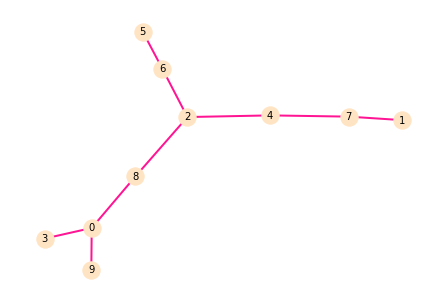

this is A_dict: 
{'0_3': [['g', 'g'], ['c', '-'], ['c', '-'], ['c', 'c'], ['t', '-'], ['a', 'a'], ['g', 't'], ['a', 'a'], ['g', 'g']], '0_8': [['g', 'a'], ['c', 'c'], ['a', '-'], ['t', 't'], ['a', 't'], ['g', 'g']], '0_9': [['-', 'c'], ['-', 'a'], ['-', 't'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'g'], ['g', 'g']], '2_8': [['a', 'g'], ['c', 't'], ['t', 't'], ['t', 't'], ['g', 'c']], '2_4': [['g', 't'], ['t', 't'], ['t', 't'], ['t', 'g'], ['c', 'c']], '2_6': [['g', 'g'], ['t', 't'], ['-', 'a'], ['-', 'a'], ['t', 'a'], ['t', 't'], ['c', 'c']], '4_7': [['t', 't'], ['t', 'g'], ['t', 'c'], ['g', 'g'], ['c', 't']], '5_6': [['-', 't'], ['g', 'g'], ['t', 'g'], ['a', 'g'], ['a', 't'], ['a', 'a'], ['t', 't'], ['c', 't']], '1_7': [['t', 'c'], ['-', 'a'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['t', '-']]}
Total cost of MSA:1240


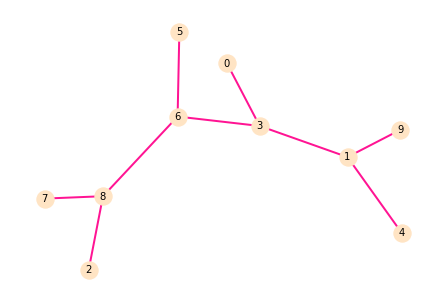

this is A_dict: 
{'1_4': [['t', 't'], ['t', 't'], ['g', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'a']], '1_3': [['t', 't'], ['t', 't'], ['g', 'g'], ['a', '-'], ['g', 'g'], ['g', 'c']], '1_9': [['t', 'a'], ['t', 't'], ['g', 'a'], ['a', 'a'], ['-', 'c'], ['g', 'a'], ['g', 'g']], '0_3': [['t', 't'], ['t', 'c'], ['g', 't'], ['g', 'a'], ['c', 'c']], '3_6': [['-', 'g'], ['t', 't'], ['t', 't'], ['g', 'c'], ['g', 'g'], ['c', 't']], '6_8': [['g', 'a'], ['t', 'a'], ['t', 't'], ['c', 'c'], ['g', 'a'], ['t', 't']], '5_6': [['g', 'a'], ['t', 'c'], ['t', 'c'], ['c', 'c'], ['-', 'g'], ['-', 'g'], ['g', 'g'], ['t', 't']], '7_8': [['a', 'a'], ['-', 'g'], ['a', 'a'], ['-', 'c'], ['t', 't'], ['c', 't'], ['a', 'a'], ['t', 'c']], '2_8': [['a', 'a'], ['a', 'a'], ['-', 'g'], ['-', 'g'], ['t', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't']]}
Total cost of MSA:1034


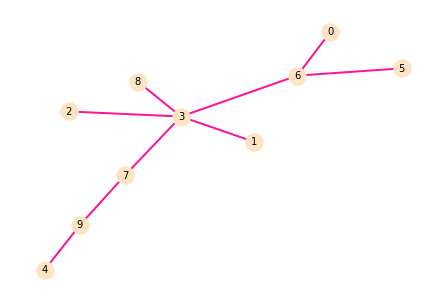

this is A_dict: 
{'0_6': [['t', 't'], ['t', 't'], ['c', 'c'], ['-', 'a'], ['t', 'a'], ['t', 'g']], '3_6': [['-', 'a'], ['t', 'a'], ['t', 't'], ['c', 'c'], ['a', '-'], ['a', 'a'], ['g', 'g']], '5_6': [['t', 't'], ['-', 'g'], ['t', 't'], ['-', 'g'], ['c', 't'], ['a', 'g'], ['a', 'a'], ['g', 'a']], '2_3': [['a', '-'], ['a', 'a'], ['t', 'c'], ['c', 'c'], ['a', 'g'], ['g', 'g'], ['-', 't']], '3_7': [['-', 't'], ['a', 'g'], ['a', 'a'], ['t', 'c'], ['c', 'c'], ['a', '-'], ['g', 'g']], '1_3': [['-', 'g'], ['a', 'a'], ['a', 'a'], ['t', 'a'], ['c', 't'], ['a', 'a'], ['g', 'g'], ['-', 'c']], '3_8': [['a', 'g'], ['a', 'g'], ['t', 't'], ['-', 'c'], ['c', 'c'], ['-', 'g'], ['a', 'a'], ['-', 'c'], ['g', 'g']], '7_9': [['t', 'a'], ['g', 'a'], ['a', 'g'], ['c', 'c'], ['c', 'c'], ['g', '-']], '4_9': [['a', 'g'], ['a', 'a'], ['g', 'g'], ['-', 't'], ['c', 't'], ['c', 't']]}
Total cost of MSA:1205


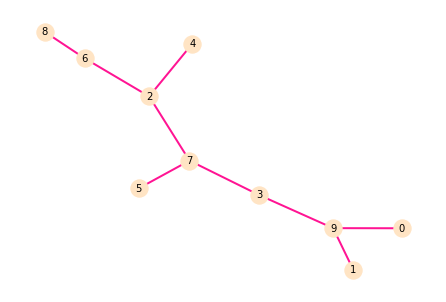

this is A_dict: 
{'6_8': [['a', 'g'], ['t', '-'], ['c', 'a'], ['c', 'c'], ['a', 'g'], ['c', 't'], ['c', 't'], ['c', 'c'], ['t', 'c']], '2_6': [['g', 'g'], ['a', '-'], ['c', 't'], ['g', 'g'], ['t', '-'], ['t', 't'], ['c', 'c'], ['c', 'c']], '2_4': [['g', 'g'], ['t', '-'], ['g', 'g'], ['t', 't'], ['c', 't'], ['c', 'c']], '2_7': [['g', 'a'], ['t', 't'], ['g', 'a'], ['t', 't'], ['c', 't'], ['c', 'a']], '5_7': [['a', 'g'], ['t', 'c'], ['a', 't'], ['t', 't'], ['t', 'a'], ['a', 'a']], '3_7': [['-', 'c'], ['a', 'a'], ['t', 'c'], ['a', 'g'], ['t', '-'], ['t', 't'], ['a', 'g']], '3_9': [['c', 'c'], ['-', 'g'], ['a', 'a'], ['c', 'g'], ['g', 'a'], ['t', 'c'], ['g', 'g']], '0_9': [['c', 'c'], ['g', 'g'], ['a', 'g'], ['g', 'g'], ['-', 'c'], ['a', 'a'], ['c', 't'], ['g', '-']], '1_9': [['c', 't'], ['g', 'a'], ['a', 'g'], ['g', 'g'], ['a', 'g'], ['-', 'c'], ['c', 'c'], ['g', 'a']]}
Total cost of MSA:1181


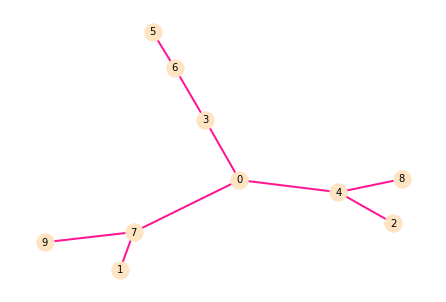

this is A_dict: 
{'2_4': [['c', 'g'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['g', '-'], ['c', 't']], '0_4': [['g', 'a'], ['t', 'a'], ['c', 'c'], ['t', 'c'], ['g', 'g'], ['a', 't'], ['t', 'c']], '4_8': [['-', 'c'], ['g', 'g'], ['t', 'c'], ['c', 'g'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['-', 'g']], '0_7': [['a', 'g'], ['a', 'a'], ['c', '-'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c']], '0_3': [['a', '-'], ['a', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c']], '7_9': [['-', 'c'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['-', 't']], '1_7': [['g', 'g'], ['a', 'g'], ['c', 't'], ['g', 'c'], ['t', 'c'], ['c', 'a']], '3_6': [['c', 't'], ['c', 't'], ['c', 'c'], ['g', 't'], ['t', 'c'], ['c', 'c']], '5_6': [['-', 'a'], ['-', 'g'], ['t', 't'], ['t', 't'], ['c', 't'], ['t', 'c'], ['c', 'c'], ['c', 't']]}
Total cost of MSA:1038
[1214, 933, 1418, 1574, 1121, 1411, 1359, 1404, 1069, 1404, 1528, 1311, 1359, 1290, 12

In [5]:
costs_new=[]
costs_old=[]
for random_pile in random_sequences_collection:
    cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
    costs_new.append(cost)
for random_pile in random_sequences_collection:
    cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
    costs_old.append(cost)
print(costs_new)
print(costs_old)
costs_new=np.array(costs_new)
costs_old=np.array(costs_old)
differences=np.subtract(costs_new,costs_old)
print(differences)

In [6]:
count=np.count_nonzero(differences<0)
print("Your algo was better than the classic in "+ str(count)+"% of the time")

Your algo was better than the classic in 13% of the time
